In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import warnings
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.inspection import PartialDependenceDisplay

In [128]:
df = pd.read_csv('/Users/lauralayton/Downloads/Chamber_GAM_model_data 2.csv')

# determine which wetlands have air temp data available
df_air_tmin_2009_JAN = pd.read_csv('/Users/lauralayton/Downloads/output/Cottonwood/_Grid_Daymet_V4_2009_JAN.csv')
available_wetlands = df_air_tmin_2009_JAN['Wetland_ID'].unique().tolist()

# filter df for only these wetlands
df = df[df['wetland_ID'].isin(available_wetlands)]
print(df['wetland_ID'].unique())

['P1' 'P3' 'P4' 'P6' 'P7' 'P8' 'T2' 'T3' 'T5' 'T6' 'T7' 'T8' 'T9']


In [129]:
# Adding Month and Year columns to the data
import datetime 
dates = df.iloc[:,1].values

def convert(date_time):
    format = '%Y-%m-%d'
    datetime_str = datetime.datetime.strptime(date_time, format)

    return datetime_str

df['Date Object'] = pd.to_datetime(df['Date'])
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Year'] = pd.to_datetime(df['Date']).dt.year

df_air_tmin_2009_JAN['DATE'] = df_air_tmin_2009_JAN['DATE'].apply(convert)

In [130]:
label_encoder = LabelEncoder()
from sklearn.metrics import mean_squared_error, r2_score
import shap

<class 'pandas.core.frame.DataFrame'>
Index: 4942 entries, 13476 to 18802
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Land_Cover_fld        4942 non-null   int64  
 1   wetland_ID            4942 non-null   int64  
 2   Hydroperiod_days_fld  4942 non-null   float64
 3   NDVI_lag_rs           4942 non-null   float64
 4   Size_m2_fld           4942 non-null   float64
 5   SoilT_C_fld           4942 non-null   float64
 6   Water_depth_cm_fld    4942 non-null   float64
 7   WFPS_pcnt_fld         4942 non-null   float64
 8   Month                 4942 non-null   int32  
 9   chamber_ID            4942 non-null   int64  
dtypes: float64(6), int32(1), int64(3)
memory usage: 405.4 KB
None
R-squared, no max depth, no year: 0.6477353400925141


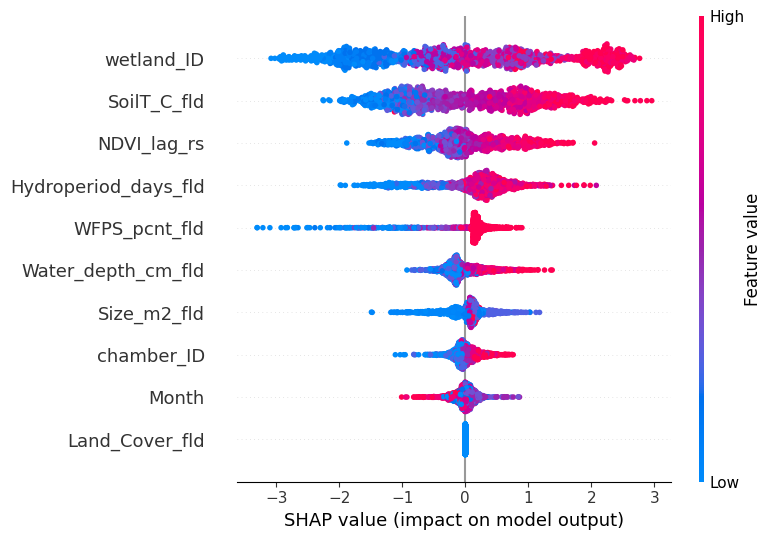

In [14]:
# train a model without year, all emissions
X_noyr = df[['Hydroperiod_days_fld', 
       'Land_Cover_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_C_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'Month', 'chamber_ID', 'wetland_ID']]
y_noyr = df['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

x_noyr_categorical = X_noyr.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_noyr_numerical = X_noyr.select_dtypes(exclude = ['object'])

x_noyr = pd.concat([x_noyr_categorical, x_noyr_numerical], axis = 1)

# print(x_pos)
print(x_noyr.info())

X_noyr_train, X_noyr_test, y_noyr_train, y_noyr_test = train_test_split(x_noyr, y_noyr, test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_noyr = RandomForestRegressor(oob_score = True)

regressor_noyr.fit(X_noyr_train, y_noyr_train)

predictions_noyr = regressor_noyr.predict(X_noyr_test)
print(f'R-squared, no max depth, no year: {r2_score(y_noyr_test, predictions_noyr)}')

# SHAP plot
explainer_noyr = shap.Explainer(regressor_noyr)

shap_values_noyr = explainer_noyr.shap_values(X_noyr_test)
shap.summary_plot(shap_values_noyr, X_noyr_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18803 entries, 0 to 18802
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hydroperiod_days_fld  18803 non-null  float64
 1   NDVI_lag_rs           18803 non-null  float64
 2   Size_m2_fld           18803 non-null  float64
 3   SoilT_C_fld           18803 non-null  float64
 4   Month                 18803 non-null  int32  
dtypes: float64(4), int32(1)
memory usage: 661.2 KB
None
R-squared, no max depth, no year, no WFPS or water depth or ID: 0.6004632021441652


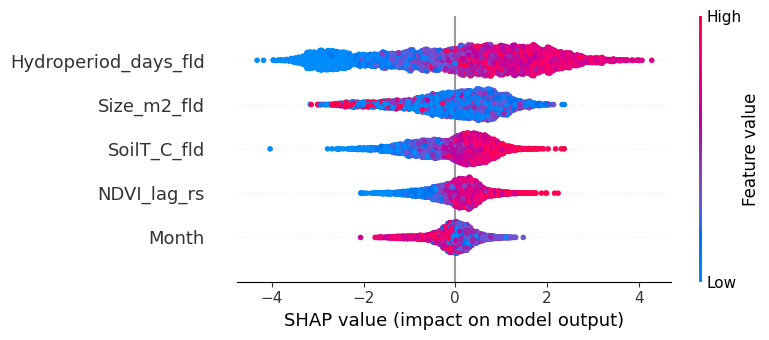

In [186]:
df_full = pd.read_csv('/Users/lauralayton/Downloads/Chamber_GAM_model_data 2.csv')
df_full['Date Object'] = pd.to_datetime(df_full['Date'])
df_full['Month'] = pd.to_datetime(df_full['Date']).dt.month
df_full['Year'] = pd.to_datetime(df_full['Date']).dt.year

# train a model without WFPS, water depth
X_noyr_wfps_water = df_full[['Hydroperiod_days_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_C_fld', 'Month']]
y_noyr_wfps_water = df_full['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

# x_noyr_wfps_water_categorical = X_noyr_wfps_water.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_noyr_wfps_water_numerical = X_noyr_wfps_water.select_dtypes(exclude = ['object'])

# x_noyr_wfps_water = pd.concat([x_noyr_wfps_water_categorical, x_noyr_wfps_water_numerical], axis = 1)
x_noyr_wfps_water = x_noyr_wfps_water_numerical

# print(x_pos)
print(x_noyr_wfps_water.info())

X_noyr_wfps_water_train, X_noyr_wfps_water_test, y_noyr_wfps_water_train, y_noyr_wfps_water_test = train_test_split(x_noyr_wfps_water, 
                                                                                                                    y_noyr_wfps_water,
                                                                                                                    test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_noyr_wfps_water = RandomForestRegressor(oob_score = True)

regressor_noyr_wfps_water.fit(X_noyr_wfps_water_train, y_noyr_wfps_water_train)

predictions_noyr_wfps_water = regressor_noyr_wfps_water.predict(X_noyr_wfps_water_test)
print(f'R-squared, no max depth, no year, no WFPS or water depth or ID: {r2_score(y_noyr_wfps_water_test, predictions_noyr_wfps_water)}')

# SHAP plot
explainer_noyr_wfps_water = shap.Explainer(regressor_noyr_wfps_water)

shap_values_noyr_wfps_water = explainer_noyr_wfps_water.shap_values(X_noyr_wfps_water_test)
shap.summary_plot(shap_values_noyr_wfps_water, X_noyr_wfps_water_test)

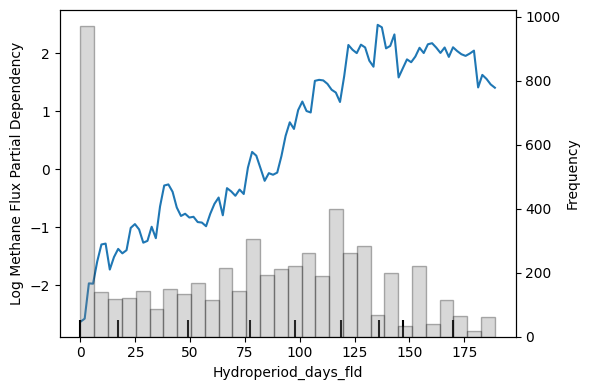

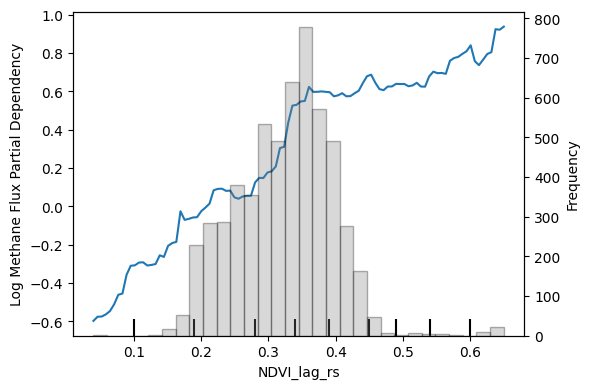

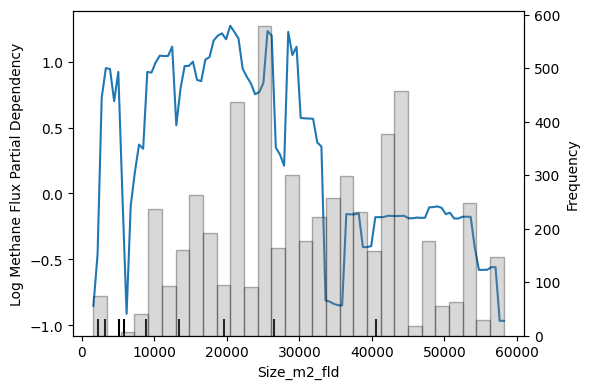

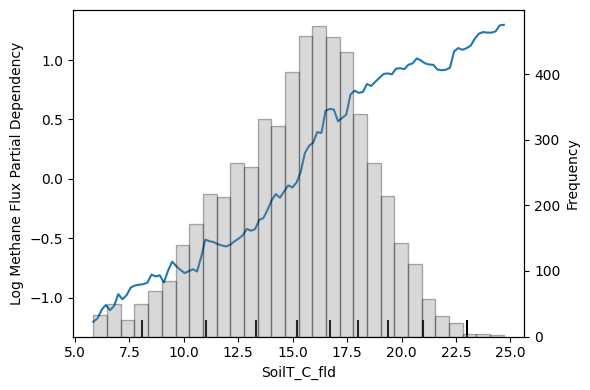

/Users/lauralayton/.pyenv/versions/venv3.12.11/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


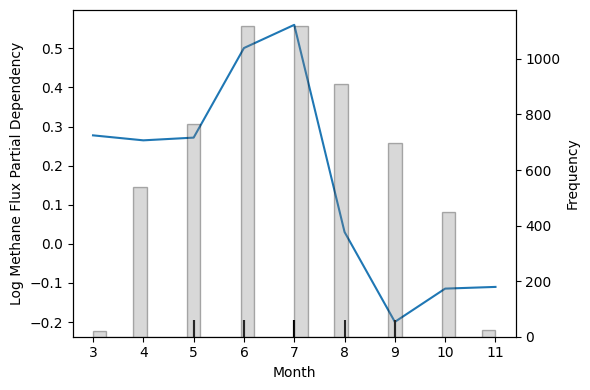

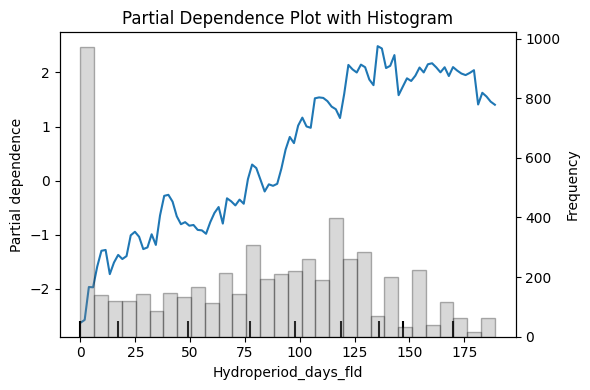

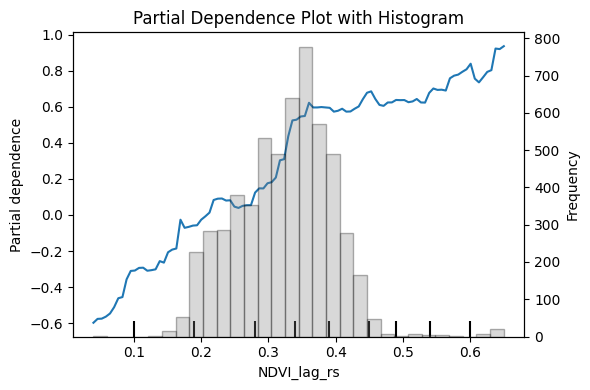

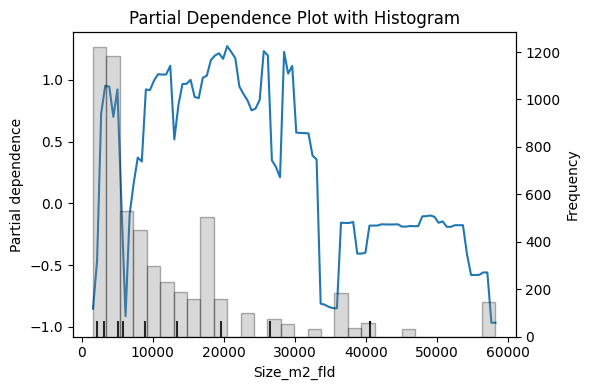

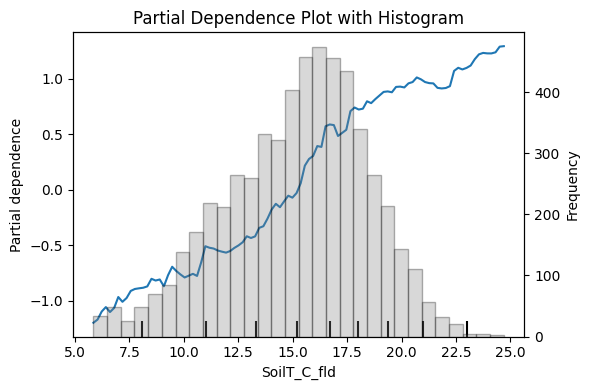

/Users/lauralayton/.pyenv/versions/venv3.12.11/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


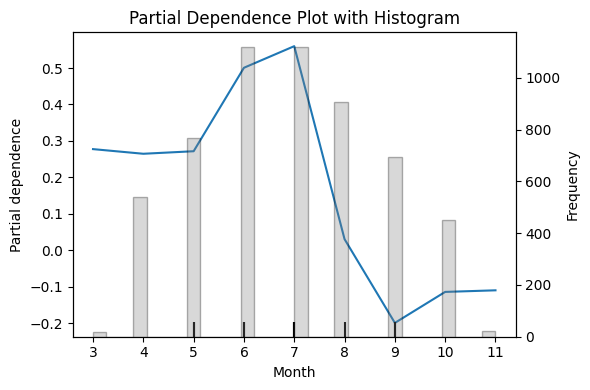

In [195]:
all_pdps2(regressor_noyr_wfps_water, X_noyr_wfps_water_test)
all_pdps(regressor_noyr_wfps_water, X_noyr_wfps_water_test)

/Users/lauralayton/.pyenv/versions/venv3.12.11/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 0 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


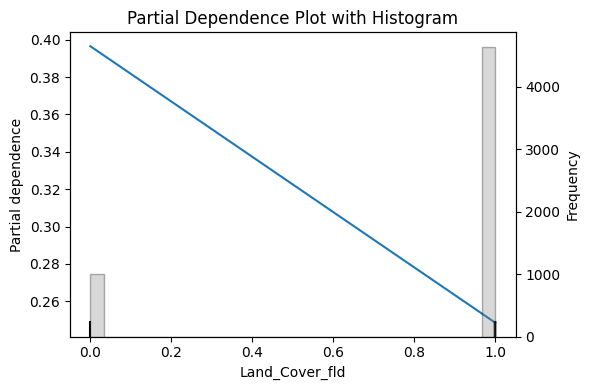

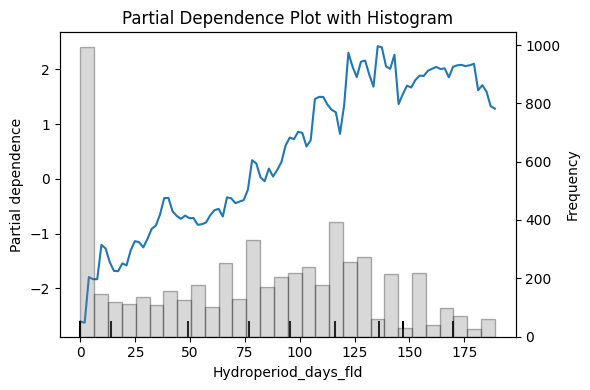

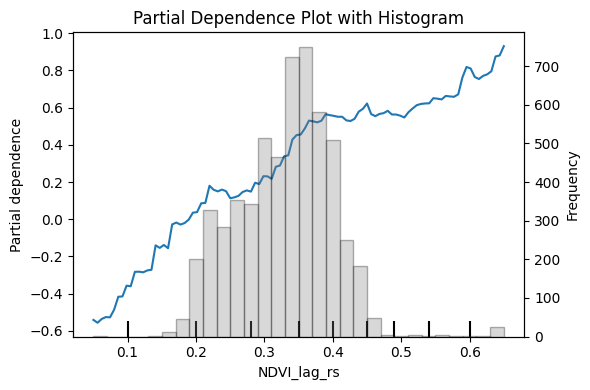

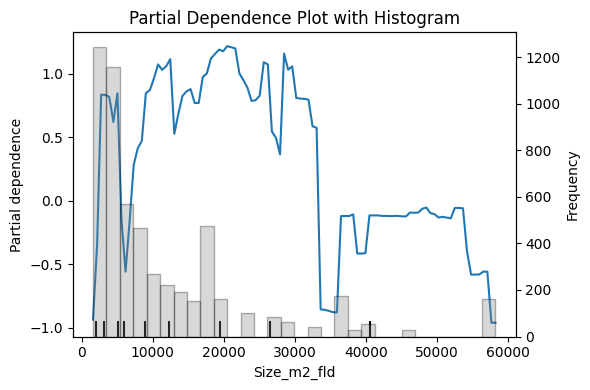

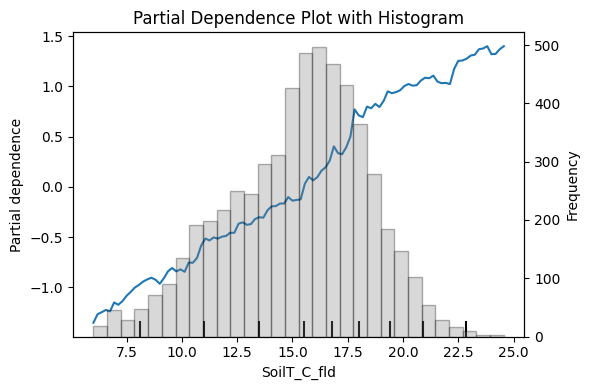

/Users/lauralayton/.pyenv/versions/venv3.12.11/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 5 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


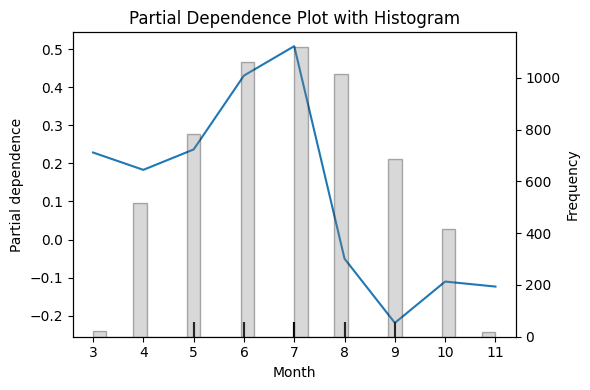

In [133]:
all_pdps(regressor_noyr_wfps_water, X_noyr_wfps_water_test)

In [127]:
df

chamber_ID       Date GS_Interval_fld  Hydroperiod_days_fld   LAB_ID  \
13476           1  5/18/2009           Early                 156.0      1.3   
13477           1   6/3/2009           Early                 156.0    153.3   
13478           1  6/18/2009           Early                 156.0    325.3   
13479           1  7/16/2009           Early                 156.0    669.0   
13480           1  7/28/2009           Early                 156.0    841.5   
...           ...        ...             ...                   ...      ...   
18798           5  5/22/2015           Early                   0.0  34216.0   
18799           5   6/4/2015           Early                   0.0  34485.0   
18800           5   7/1/2015           Early                   0.0  34977.0   
18801           5  7/16/2015           Early                   0.0  35223.0   
18802           5  7/30/2015            Late                   0.0    960.7   

      Land_Cover_fld  methane_flux_log_mg_m2_hr  NDVI_lag_rs  NDVI_rs  \
13476          Grass                  -2.383779         0.03     0.03   
13477          Grass                  -1.714138         0.03     0.11   
13478          Grass                  -1.042693         0.11     0.27   
13479          Grass                  -1.905919         0.27     0.39   
13480          Grass                  -1.468251         0.39     0.39   
...              ...                        ...          ...      ...   
18798          Grass                  -6.371262         0.37     0.45   
18799          Grass                  -2.653150         0.45     0.53   
18800          Grass                  -1.672548         0.53     0.59   
18801          Grass                  -1.952675         0.59     0.66   
18802          Grass                  -4.431536         0.66     0.67   

       Size_m2_fld  SoilT_C_fld  SoilT_lag_C_fld  Water_depth_cm_fld  \
13476      58200.0         14.2             14.2               130.0   
13477      58200.0         18.4             14.2               128.0   
13478      58200.0         21.7             18.4               123.0   
13479      58200.0         17.2             21.7               120.0   
13480      58200.0         22.5             17.2               105.0   
...            ...          ...              ...                 ...   
18798      11500.0          8.5              8.7                 0.0   
18799      11500.0         11.4              8.5                 0.0   
18800      11500.0         16.3             11.4                 0.0   
18801      11500.0         16.9             16.3                 0.0   
18802      11500.0         16.6             16.9                 0.0   

      Wetland_Chamber wetland_ID  WFPS_lag_pcnt_fld  WFPS_pcnt_fld  
13476            P1_1         P1         100.000000     100.000000  
13477            P1_1         P1         100.000000     100.000000  
13478            P1_1         P1         100.000000     100.000000  
13479            P1_1         P1         100.000000     100.000000  
13480            P1_1         P1         100.000000     100.000000  
...               ...        ...                ...            ...  
18798            T9_5         T9          60.498386      62.698328  
18799            T9_5         T9          62.698328      51.855760  
18800            T9_5         T9          51.855760      69.769568  
18801            T9_5         T9          69.769568      58.769861  
18802            T9_5         T9          58.769861      38.813250  

[4942 rows x 17 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 4942 entries, 13476 to 18802
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Land_Cover_fld        4942 non-null   int64  
 1   wetland_ID            4942 non-null   int64  
 2   Hydroperiod_days_fld  4942 non-null   float64
 3   NDVI_lag_rs           4942 non-null   float64
 4   Size_m2_fld           4942 non-null   float64
 5   Water_depth_cm_fld    4942 non-null   float64
 6   WFPS_pcnt_fld         4942 non-null   float64
 7   Month                 4942 non-null   int32  
 8   chamber_ID            4942 non-null   int64  
dtypes: float64(5), int32(1), int64(3)
memory usage: 366.8 KB
None
R-squared, no max depth, no year, no soil temp: 0.6482768309820547


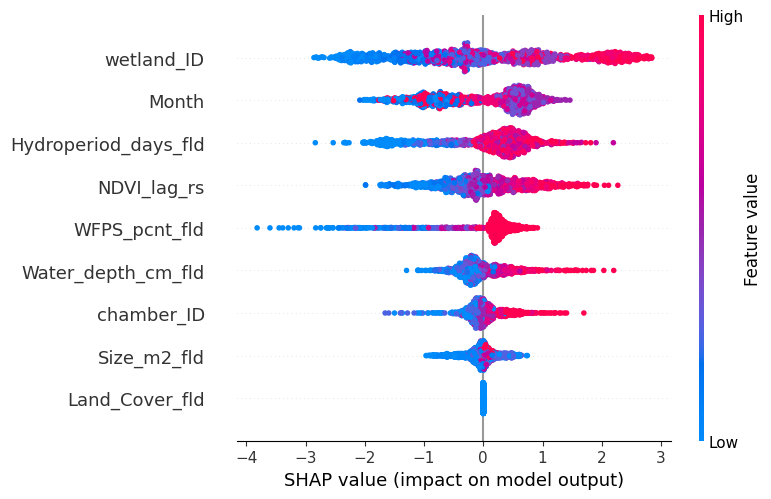

In [20]:
# train a model without soil_temp, all emissions
X_nosoil = df[['Hydroperiod_days_fld', 
       'Land_Cover_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'Water_depth_cm_fld',
        'WFPS_pcnt_fld', 'Month', 'chamber_ID', 'wetland_ID']]
y_nosoil = df['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

x_nosoil_categorical = X_nosoil.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_nosoil_numerical = X_nosoil.select_dtypes(exclude = ['object'])

x_nosoil = pd.concat([x_nosoil_categorical, x_nosoil_numerical], axis = 1)

# print(x_pos)
print(x_nosoil.info())

X_nosoil_train, X_nosoil_test, y_nosoil_train, y_nosoil_test = train_test_split(x_nosoil, y_nosoil, test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_nosoil = RandomForestRegressor(oob_score = True)

regressor_nosoil.fit(X_nosoil_train, y_nosoil_train)

predictions_nosoil = regressor_nosoil.predict(X_nosoil_test)
print(f'R-squared, no max depth, no year, no soil temp: {r2_score(y_nosoil_test, predictions_nosoil)}')

# SHAP plot
explainer_nosoil = shap.Explainer(regressor_nosoil)

shap_values_nosoil = explainer_nosoil.shap_values(X_nosoil_test)
shap.summary_plot(shap_values_nosoil, X_nosoil_test)

<class 'pandas.core.frame.DataFrame'>
Index: 4942 entries, 13476 to 18802
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Land_Cover_fld        4942 non-null   int64  
 1   wetland_ID            4942 non-null   int64  
 2   Hydroperiod_days_fld  4942 non-null   float64
 3   NDVI_lag_rs           4942 non-null   float64
 4   Size_m2_fld           4942 non-null   float64
 5   SoilT_C_fld           4942 non-null   float64
 6   WFPS_pcnt_fld         4942 non-null   float64
 7   Month                 4942 non-null   int32  
 8   chamber_ID            4942 non-null   int64  
dtypes: float64(5), int32(1), int64(3)
memory usage: 366.8 KB
None
R-squared, no max depth, no year, no water depth: 0.6454438531997757


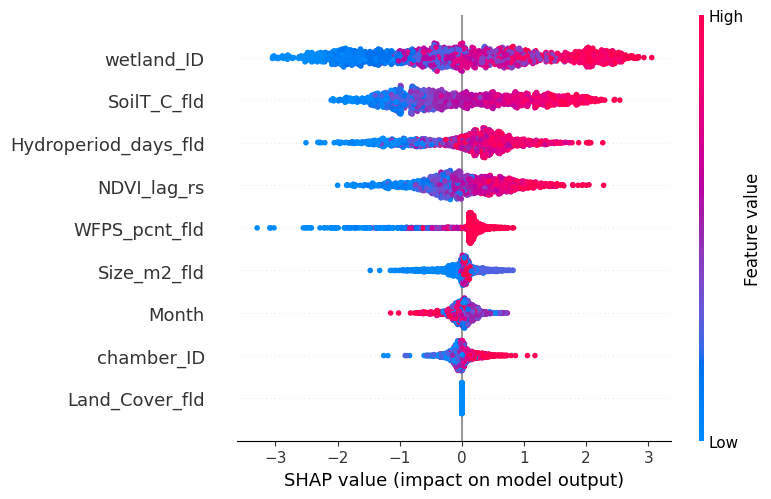

In [21]:
# train a model without water depth, all emissions
X_nowater = df[['Hydroperiod_days_fld', 
       'Land_Cover_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_C_fld',
        'WFPS_pcnt_fld', 'Month', 'chamber_ID', 'wetland_ID']]
y_nowater = df['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

x_nowater_categorical = X_nowater.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_nowater_numerical = X_nowater.select_dtypes(exclude = ['object'])

x_nowater = pd.concat([x_nowater_categorical, x_nowater_numerical], axis = 1)

# print(x_pos)
print(x_nowater.info())

X_nowater_train, X_nowater_test, y_nowater_train, y_nowater_test = train_test_split(x_nowater, y_nowater, test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_nowater = RandomForestRegressor(oob_score = True)

regressor_nowater.fit(X_nowater_train, y_nowater_train)

predictions_nowater = regressor_nowater.predict(X_nowater_test)
print(f'R-squared, no max depth, no year, no water depth: {r2_score(y_nowater_test, predictions_nowater)}')

# SHAP plot
explainer_nowater = shap.Explainer(regressor_nowater)

shap_values_nowater = explainer_nowater.shap_values(X_nowater_test)
shap.summary_plot(shap_values_nowater, X_nowater_test)

<class 'pandas.core.frame.DataFrame'>
Index: 4942 entries, 13476 to 18802
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   wetland_ID            4942 non-null   int64  
 1   Hydroperiod_days_fld  4942 non-null   float64
 2   NDVI_lag_rs           4942 non-null   float64
 3   Size_m2_fld           4942 non-null   float64
 4   SoilT_C_fld           4942 non-null   float64
 5   WFPS_pcnt_fld         4942 non-null   float64
 6   Month                 4942 non-null   int32  
 7   chamber_ID            4942 non-null   int64  
dtypes: float64(5), int32(1), int64(2)
memory usage: 328.2 KB
None
R-squared, no max depth, no year, no water depth, no land cover: 0.6492544063835115


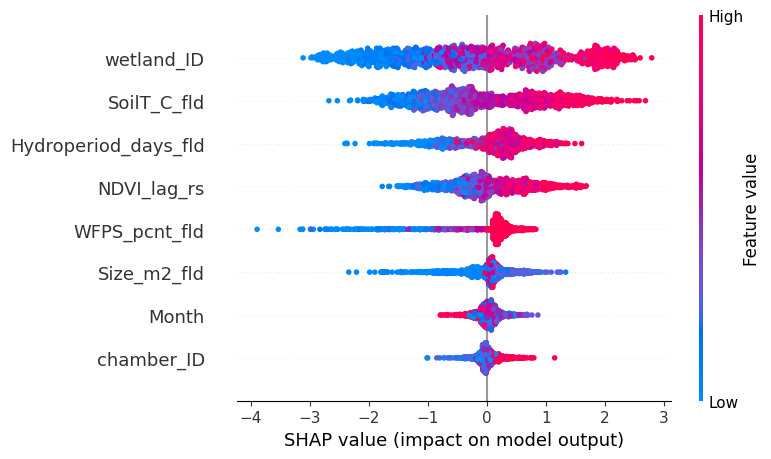

In [23]:
# train a model without water depth, land cover, with all emissions
X_nowater_lcover = df[['Hydroperiod_days_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_C_fld',
        'WFPS_pcnt_fld', 'Month', 'chamber_ID', 'wetland_ID']]
y_nowater_lcover = df['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

x_nowater_lcover_categorical = X_nowater_lcover.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_nowater_lcover_numerical = X_nowater_lcover.select_dtypes(exclude = ['object'])

x_nowater_lcover = pd.concat([x_nowater_lcover_categorical, x_nowater_lcover_numerical], axis = 1)

# print(x_pos)
print(x_nowater_lcover.info())

X_nowater_lcover_train, X_nowater_lcover_test, y_nowater_lcover_train, y_nowater_lcover_test = train_test_split(x_nowater_lcover, 
                                                                                                                y_nowater_lcover, 
                                                                                                                test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_nowater_lcover = RandomForestRegressor(oob_score = True)

regressor_nowater_lcover.fit(X_nowater_lcover_train, y_nowater_lcover_train)

predictions_nowater_lcover = regressor_nowater_lcover.predict(X_nowater_lcover_test)
print(f'R-squared, no max depth, no year, no water depth, no land cover: {r2_score(y_nowater_lcover_test, 
                                                                                   predictions_nowater_lcover)}')

# SHAP plot
explainer_nowater_lcover = shap.Explainer(regressor_nowater_lcover)

shap_values_nowater_lcover = explainer_nowater_lcover.shap_values(X_nowater_lcover_test)
shap.summary_plot(shap_values_nowater_lcover, X_nowater_lcover_test)

In [15]:
df

chamber_ID       Date GS_Interval_fld  Hydroperiod_days_fld   LAB_ID  \
13476           1  5/18/2009           Early                 156.0      1.3   
13477           1   6/3/2009           Early                 156.0    153.3   
13478           1  6/18/2009           Early                 156.0    325.3   
13479           1  7/16/2009           Early                 156.0    669.0   
13480           1  7/28/2009           Early                 156.0    841.5   
...           ...        ...             ...                   ...      ...   
18798           5  5/22/2015           Early                   0.0  34216.0   
18799           5   6/4/2015           Early                   0.0  34485.0   
18800           5   7/1/2015           Early                   0.0  34977.0   
18801           5  7/16/2015           Early                   0.0  35223.0   
18802           5  7/30/2015            Late                   0.0    960.7   

      Land_Cover_fld  methane_flux_log_mg_m2_hr  NDVI_lag_rs  NDVI_rs  \
13476          Grass                  -2.383779         0.03     0.03   
13477          Grass                  -1.714138         0.03     0.11   
13478          Grass                  -1.042693         0.11     0.27   
13479          Grass                  -1.905919         0.27     0.39   
13480          Grass                  -1.468251         0.39     0.39   
...              ...                        ...          ...      ...   
18798          Grass                  -6.371262         0.37     0.45   
18799          Grass                  -2.653150         0.45     0.53   
18800          Grass                  -1.672548         0.53     0.59   
18801          Grass                  -1.952675         0.59     0.66   
18802          Grass                  -4.431536         0.66     0.67   

       Size_m2_fld  SoilT_C_fld  SoilT_lag_C_fld  Water_depth_cm_fld  \
13476      58200.0         14.2             14.2               130.0   
13477      58200.0         18.4             14.2               128.0   
13478      58200.0         21.7             18.4               123.0   
13479      58200.0         17.2             21.7               120.0   
13480      58200.0         22.5             17.2               105.0   
...            ...          ...              ...                 ...   
18798      11500.0          8.5              8.7                 0.0   
18799      11500.0         11.4              8.5                 0.0   
18800      11500.0         16.3             11.4                 0.0   
18801      11500.0         16.9             16.3                 0.0   
18802      11500.0         16.6             16.9                 0.0   

      Wetland_Chamber wetland_ID  WFPS_lag_pcnt_fld  WFPS_pcnt_fld  \
13476            P1_1         P1         100.000000     100.000000   
13477            P1_1         P1         100.000000     100.000000   
13478            P1_1         P1         100.000000     100.000000   
13479            P1_1         P1         100.000000     100.000000   
13480            P1_1         P1         100.000000     100.000000   
...               ...        ...                ...            ...   
18798            T9_5         T9          60.498386      62.698328   
18799            T9_5         T9          62.698328      51.855760   
18800            T9_5         T9          51.855760      69.769568   
18801            T9_5         T9          69.769568      58.769861   
18802            T9_5         T9          58.769861      38.813250   

      Date Object  Month  Year  
13476  2009-05-18      5  2009  
13477  2009-06-03      6  2009  
13478  2009-06-18      6  2009  
13479  2009-07-16      7  2009  
13480  2009-07-28      7  2009  
...           ...    ...   ...  
18798  2015-05-22      5  2015  
18799  2015-06-04      6  2015  
18800  2015-07-01      7  2015  
18801  2015-07-16      7  2015  
18802  2015-07-30      7  2015  

[4942 rows x 20 columns]

In [16]:
# determine variation in soil temperature across wetlands on a certain day
df_dates = df['Date Object'].unique().tolist()

for date in df_dates:
    df_subset = df[df['Date Object'] == date]
    print(np.var(df_subset['SoilT_C_fld']))

# okay so sometimes the variance is fully 30 degrees C

1.465000000000001
12.28923469387755
7.213112244897961
5.605969387755102
11.991388888888887
14.97444234404537
9.866666666666667
1.98484375
0.28543209876543213
0.8460207612456747
0.6339229024943313
9.91301775147929
4.730796670630201
9.259738406658741
6.136266666666668
2.6202666666666667
3.6629333333333336
2.9800999999999993
7.342906574394466
6.828935986159166
1.3574305555555555
1.7466666666666668
1.4517561983471072
0.5624489795918366
2.1066666666666665
2.1180555555555554
17.071733333333334
2.404622222222222
3.462488888888891
5.5808888888888895
13.065306122448982
4.758826530612245
4.322222222222224
6.493520408163263
14.189066666666667
4.025999999999998
0.7485937499999998
1.6738775510204076
1.9679289940828397
0.14244897959183683
0.02888888888888889
5.204166666666667
0.061224489795918435
1.550562414266118
11.798275
9.7306
9.411683673469387
5.76248888888889
9.652430555555554
8.181999999999999
3.4543999999999997
1.2801000000000005
1.3709000000000002
2.845917159763314
6.009722222222222
9.09632

In [19]:
# determine variation in soil temperature across wetlands on a certain day
air_dates = df_air_tmin_2009_JAN['DATE'].unique().tolist()

for date in air_dates:
    df_subset = df_air_tmin_2009_JAN[df_air_tmin_2009_JAN['DATE'] == date]
    print(np.var(df_subset['tmin']))

0.024979234414190712
0.0016944819345740853
0.0005247125576240451
0.0010560181862536678
0.05503246584176115
0.0017120990975020623
0.001767769459028922
0.03213195901029887
1.035544365685936e-06
0.010308863712872027
0.03909355365015782
0.03891797225009012
0.012234817714417518
0.016437867013924776
0.0026046779581052476
0.00357800515182035
0.0017457011557233412
0.015341819308808659
0.013199329216604981
0.008411457580503557
0.0017356252836652985
0.000795357483292957
0.015365778335910525
0.01649315035678405
0.012102746153958609
0.011081843973970789
0.020249760411858327
0.03382514285746348
0.03382432977043214
0.01673023033906155
0.0016156987080646788


In [26]:
# okay now put the air temperature data on
file_ends = ['2009_JAN', '2009_FEB', '2009_MAR', '2009_APR', '2009_MAY', '2009_JUN',
            '2009_JUL', '2009_AUG', '2009_SEP', '2009_OCT', '2009_NOV', '2009_DEC',
            '2010_JAN', '2010_FEB', '2010_MAR', '2010_APR', '2010_MAY', '2010_JUN',
            '2010_JUL', '2010_AUG', '2010_SEP', '2010_OCT', '2010_NOV', '2010_DEC',
            '2011_JAN', '2011_FEB', '2011_MAR', '2011_APR', '2011_MAY', '2011_JUN',
            '2011_JUL', '2011_AUG', '2011_SEP', '2011_OCT', '2011_NOV', '2011_DEC',
            '2012_JAN', '2012_FEB', '2012_MAR', '2012_APR', '2012_MAY', '2012_JUN',
            '2012_JUL', '2012_AUG', '2012_SEP', '2012_OCT', '2012_NOV', '2012_DEC',
            '2013_JAN', '2013_FEB', '2013_MAR', '2013_APR', '2013_MAY', '2013_JUN',
            '2013_JUL', '2013_AUG', '2013_SEP', '2013_OCT', '2013_NOV', '2013_DEC',
            '2014_JAN', '2014_FEB', '2014_MAR', '2014_APR', '2014_MAY', '2014_JUN',
            '2014_JUL', '2014_AUG', '2014_SEP', '2014_OCT', '2014_NOV', '2014_DEC',
            '2015_JAN', '2015_FEB', '2015_MAR', '2015_APR', '2015_MAY', '2015_JUN',
            '2015_JUL', '2015_AUG', '2015_SEP', '2015_OCT', '2015_NOV', '2015_DEC',
            '2016_JAN', '2016_FEB', '2016_MAR', '2016_APR', '2016_MAY', '2016_JUN',
            '2016_JUL', '2016_AUG', '2016_SEP', '2016_OCT', '2016_NOV', '2016_DEC',]

# make a dataframe for the tmin values

df_air_tmin = pd.read_csv('/Users/lauralayton/Downloads/output/Cottonwood/_Grid_Daymet_V4_2009_JAN.csv')
df_air_tmin['DATE'] = df_air_tmin['DATE'].apply(convert)
df_air_tmin  = df_air_tmin[df_air_tmin['DATE'].isin(df_dates)]


for i in range(len(file_ends)):
    file_end = file_ends[i]
    file_path = '/Users/lauralayton/Downloads/output/Cottonwood/_Grid_Daymet_V4_' + file_end + '.csv'
    df_temp = pd.read_csv(file_path)
    df_temp['DATE'] = df_temp['DATE'].apply(convert)
    df_temp = df_temp[df_temp['DATE'].isin(df_dates)]

    if i > 0:
        df_air_tmin = pd.concat([df_air_tmin, df_temp])

In [27]:
df_air_tmin

CELL_AREA_M2       DATE        LAT       LONG Wetland_ID  tmin
21420    611.212083 2009-05-18  47.105902 -99.143150        P11  4.19
21421    611.212083 2009-05-18  47.105902 -99.142881        P11  4.19
21422    611.208989 2009-05-18  47.106171 -99.143959        P11  4.19
21423    611.208989 2009-05-18  47.106171 -99.143689        P11  4.19
21424    611.208989 2009-05-18  47.106171 -99.143420        P11  4.19
...             ...        ...        ...        ...        ...   ...
21415    611.289438 2016-11-17  47.099164 -99.095450         T4  0.04
21416    611.289438 2016-11-17  47.099164 -99.095180         T4  0.04
21417    611.286344 2016-11-17  47.099434 -99.095719         T4  0.04
21418    611.286344 2016-11-17  47.099434 -99.095450         T4  0.04
21419    611.286344 2016-11-17  47.099434 -99.095180         T4  0.04

[545580 rows x 6 columns]

In [35]:
air_tmin_dates = df_air_tmin['DATE'].unique().tolist()

for air_date in air_tmin_dates:
    if air_date in df_dates:
        continue
    else:
        print(air_date)

for date in df_dates:
    if date in air_tmin_dates:
        continue
    else:
        print(date)

# okay the two are the same list

In [ ]:
# now make the dataframe of tmax values

In [36]:
# okay now put the air temperature data on
file_ends = ['2009_JAN', '2009_FEB', '2009_MAR', '2009_APR', '2009_MAY', '2009_JUN',
            '2009_JUL', '2009_AUG', '2009_SEP', '2009_OCT', '2009_NOV', '2009_DEC',
            '2010_JAN', '2010_FEB', '2010_MAR', '2010_APR', '2010_MAY', '2010_JUN',
            '2010_JUL', '2010_AUG', '2010_SEP', '2010_OCT', '2010_NOV', '2010_DEC',
            '2011_JAN', '2011_FEB', '2011_MAR', '2011_APR', '2011_MAY', '2011_JUN',
            '2011_JUL', '2011_AUG', '2011_SEP', '2011_OCT', '2011_NOV', '2011_DEC',
            '2012_JAN', '2012_FEB', '2012_MAR', '2012_APR', '2012_MAY', '2012_JUN',
            '2012_JUL', '2012_AUG', '2012_SEP', '2012_OCT', '2012_NOV', '2012_DEC',
            '2013_JAN', '2013_FEB', '2013_MAR', '2013_APR', '2013_MAY', '2013_JUN',
            '2013_JUL', '2013_AUG', '2013_SEP', '2013_OCT', '2013_NOV', '2013_DEC',
            '2014_JAN', '2014_FEB', '2014_MAR', '2014_APR', '2014_MAY', '2014_JUN',
            '2014_JUL', '2014_AUG', '2014_SEP', '2014_OCT', '2014_NOV', '2014_DEC',
            '2015_JAN', '2015_FEB', '2015_MAR', '2015_APR', '2015_MAY', '2015_JUN',
            '2015_JUL', '2015_AUG', '2015_SEP', '2015_OCT', '2015_NOV', '2015_DEC',
            '2016_JAN', '2016_FEB', '2016_MAR', '2016_APR', '2016_MAY', '2016_JUN',
            '2016_JUL', '2016_AUG', '2016_SEP', '2016_OCT', '2016_NOV', '2016_DEC',]

# make a dataframe for the tmin values

df_air_tmax = pd.read_csv('/Users/lauralayton/Downloads/output/Cottonwood/_Grid_Daymet_V4_tmax_2009_JAN.csv')
df_air_tmax['DATE'] = df_air_tmax['DATE'].apply(convert)
df_air_tmax  = df_air_tmax[df_air_tmax['DATE'].isin(df_dates)]


for i in range(len(file_ends)):
    file_end = file_ends[i]
    file_path = '/Users/lauralayton/Downloads/output/Cottonwood/_Grid_Daymet_V4_tmax_' + file_end + '.csv'
    df_temp = pd.read_csv(file_path)
    df_temp['DATE'] = df_temp['DATE'].apply(convert)
    df_temp = df_temp[df_temp['DATE'].isin(df_dates)]

    if i > 0:
        df_air_tmax = pd.concat([df_air_tmax, df_temp])

In [37]:
df_air_tmax

CELL_AREA_M2       DATE        LAT       LONG Wetland_ID   tmax
21420    611.212083 2009-05-18  47.105902 -99.143150        P11  24.34
21421    611.212083 2009-05-18  47.105902 -99.142881        P11  24.34
21422    611.208989 2009-05-18  47.106171 -99.143959        P11  24.34
21423    611.208989 2009-05-18  47.106171 -99.143689        P11  24.34
21424    611.208989 2009-05-18  47.106171 -99.143420        P11  24.34
...             ...        ...        ...        ...        ...    ...
21415    611.289438 2016-11-17  47.099164 -99.095450         T4   2.20
21416    611.289438 2016-11-17  47.099164 -99.095180         T4   2.20
21417    611.286344 2016-11-17  47.099434 -99.095719         T4   2.20
21418    611.286344 2016-11-17  47.099434 -99.095450         T4   2.20
21419    611.286344 2016-11-17  47.099434 -99.095180         T4   2.20

[545580 rows x 6 columns]

In [45]:
# Re-index df since it's only P and T wetlands now
df_PT = df.reset_index(drop = True)

# now put the tmin and tmax columns onto the dataframe with all the other variables

df_PT['AIR_TMIN_C'] = np.nan
df_PT['AIR_TMAX_C'] = np.nan

tminloc = df_PT.columns.get_loc('AIR_TMIN_C')
tmaxloc = df_PT.columns.get_loc('AIR_TMAX_C')

for index, row in df_PT.iterrows():
    wetland_ID = row['wetland_ID']
    date = row['Date Object']
    
    tmin_subset = df_air_tmin[(df_air_tmin['DATE'] == date) &
        (df_air_tmin['Wetland_ID'] == wetland_ID)]
    tmin_avg = np.mean(tmin_subset['tmin'])

    tmax_subset = df_air_tmax[(df_air_tmax['DATE'] == date) &
        (df_air_tmax['Wetland_ID'] == wetland_ID)]
    tmax_avg = np.mean(tmax_subset['tmax'].tolist())

    df_PT.iloc[index, tminloc] = tmin_avg
    df_PT.iloc[index, tmaxloc] = tmax_avg
    

In [46]:
df_PT

chamber_ID       Date GS_Interval_fld  Hydroperiod_days_fld   LAB_ID  \
0              1  5/18/2009           Early                 156.0      1.3   
1              1   6/3/2009           Early                 156.0    153.3   
2              1  6/18/2009           Early                 156.0    325.3   
3              1  7/16/2009           Early                 156.0    669.0   
4              1  7/28/2009           Early                 156.0    841.5   
...          ...        ...             ...                   ...      ...   
4937           5  5/22/2015           Early                   0.0  34216.0   
4938           5   6/4/2015           Early                   0.0  34485.0   
4939           5   7/1/2015           Early                   0.0  34977.0   
4940           5  7/16/2015           Early                   0.0  35223.0   
4941           5  7/30/2015            Late                   0.0    960.7   

     Land_Cover_fld  methane_flux_log_mg_m2_hr  NDVI_lag_rs  NDVI_rs  \
0             Grass                  -2.383779         0.03     0.03   
1             Grass                  -1.714138         0.03     0.11   
2             Grass                  -1.042693         0.11     0.27   
3             Grass                  -1.905919         0.27     0.39   
4             Grass                  -1.468251         0.39     0.39   
...             ...                        ...          ...      ...   
4937          Grass                  -6.371262         0.37     0.45   
4938          Grass                  -2.653150         0.45     0.53   
4939          Grass                  -1.672548         0.53     0.59   
4940          Grass                  -1.952675         0.59     0.66   
4941          Grass                  -4.431536         0.66     0.67   

      Size_m2_fld  ...  Water_depth_cm_fld  Wetland_Chamber  wetland_ID  \
0         58200.0  ...               130.0             P1_1          P1   
1         58200.0  ...               128.0             P1_1          P1   
2         58200.0  ...               123.0             P1_1          P1   
3         58200.0  ...               120.0             P1_1          P1   
4         58200.0  ...               105.0             P1_1          P1   
...           ...  ...                 ...              ...         ...   
4937      11500.0  ...                 0.0             T9_5          T9   
4938      11500.0  ...                 0.0             T9_5          T9   
4939      11500.0  ...                 0.0             T9_5          T9   
4940      11500.0  ...                 0.0             T9_5          T9   
4941      11500.0  ...                 0.0             T9_5          T9   

     WFPS_lag_pcnt_fld WFPS_pcnt_fld  Date Object  Month  Year  AIR_TMIN_C  \
0           100.000000    100.000000   2009-05-18      5  2009    3.766267   
1           100.000000    100.000000   2009-06-03      6  2009    2.925106   
2           100.000000    100.000000   2009-06-18      6  2009   15.052324   
3           100.000000    100.000000   2009-07-16      7  2009    6.510458   
4           100.000000    100.000000   2009-07-28      7  2009    9.216972   
...                ...           ...          ...    ...   ...         ...   
4937         60.498386     62.698328   2015-05-22      5  2015    6.180000   
4938         62.698328     51.855760   2015-06-04      6  2015    8.670000   
4939         51.855760     69.769568   2015-07-01      7  2015   15.710000   
4940         69.769568     58.769861   2015-07-16      7  2015   16.959999   
4941         58.769861     38.813250   2015-07-30      7  2015   12.380000   

      AIR_TMAX_C  
0      24.065105  
1      20.843944  
2      22.205106  
3      19.323943  
4      22.693944  
...          ...  
4937   22.770000  
4938   20.370001  
4939   24.870001  
4940   26.180000  
4941   27.670000  

[4942 rows x 22 columns]

In [53]:
# now create a column for the average air temp
df_PT['AIR_TEMP_AVG_C'] = np.nan

avgloc = df_PT.columns.get_loc('AIR_TEMP_AVG_C')

for index, row in df_PT.iterrows():
    avg = (row['AIR_TMIN_C'] + row['AIR_TMAX_C'])/2

    df_PT.iloc[index, avgloc] = avg

In [54]:
df_PT

chamber_ID       Date GS_Interval_fld  Hydroperiod_days_fld   LAB_ID  \
0              1  5/18/2009           Early                 156.0      1.3   
1              1   6/3/2009           Early                 156.0    153.3   
2              1  6/18/2009           Early                 156.0    325.3   
3              1  7/16/2009           Early                 156.0    669.0   
4              1  7/28/2009           Early                 156.0    841.5   
...          ...        ...             ...                   ...      ...   
4937           5  5/22/2015           Early                   0.0  34216.0   
4938           5   6/4/2015           Early                   0.0  34485.0   
4939           5   7/1/2015           Early                   0.0  34977.0   
4940           5  7/16/2015           Early                   0.0  35223.0   
4941           5  7/30/2015            Late                   0.0    960.7   

     Land_Cover_fld  methane_flux_log_mg_m2_hr  NDVI_lag_rs  NDVI_rs  \
0             Grass                  -2.383779         0.03     0.03   
1             Grass                  -1.714138         0.03     0.11   
2             Grass                  -1.042693         0.11     0.27   
3             Grass                  -1.905919         0.27     0.39   
4             Grass                  -1.468251         0.39     0.39   
...             ...                        ...          ...      ...   
4937          Grass                  -6.371262         0.37     0.45   
4938          Grass                  -2.653150         0.45     0.53   
4939          Grass                  -1.672548         0.53     0.59   
4940          Grass                  -1.952675         0.59     0.66   
4941          Grass                  -4.431536         0.66     0.67   

      Size_m2_fld  ...  Wetland_Chamber  wetland_ID  WFPS_lag_pcnt_fld  \
0         58200.0  ...             P1_1          P1         100.000000   
1         58200.0  ...             P1_1          P1         100.000000   
2         58200.0  ...             P1_1          P1         100.000000   
3         58200.0  ...             P1_1          P1         100.000000   
4         58200.0  ...             P1_1          P1         100.000000   
...           ...  ...              ...         ...                ...   
4937      11500.0  ...             T9_5          T9          60.498386   
4938      11500.0  ...             T9_5          T9          62.698328   
4939      11500.0  ...             T9_5          T9          51.855760   
4940      11500.0  ...             T9_5          T9          69.769568   
4941      11500.0  ...             T9_5          T9          58.769861   

     WFPS_pcnt_fld Date Object  Month  Year AIR_TMIN_C  AIR_TMAX_C  \
0       100.000000  2009-05-18      5  2009   3.766267   24.065105   
1       100.000000  2009-06-03      6  2009   2.925106   20.843944   
2       100.000000  2009-06-18      6  2009  15.052324   22.205106   
3       100.000000  2009-07-16      7  2009   6.510458   19.323943   
4       100.000000  2009-07-28      7  2009   9.216972   22.693944   
...            ...         ...    ...   ...        ...         ...   
4937     62.698328  2015-05-22      5  2015   6.180000   22.770000   
4938     51.855760  2015-06-04      6  2015   8.670000   20.370001   
4939     69.769568  2015-07-01      7  2015  15.710000   24.870001   
4940     58.769861  2015-07-16      7  2015  16.959999   26.180000   
4941     38.813250  2015-07-30      7  2015  12.380000   27.670000   

      AIR_TEMP_AVG_C  
0          13.915686  
1          11.884525  
2          18.628715  
3          12.917200  
4          15.955458  
...              ...  
4937       14.475000  
4938       14.520000  
4939       20.290000  
4940       21.570000  
4941       20.025000  

[4942 rows x 23 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4942 entries, 0 to 4941
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   wetland_ID            4942 non-null   int64  
 1   Hydroperiod_days_fld  4942 non-null   float64
 2   NDVI_lag_rs           4942 non-null   float64
 3   Size_m2_fld           4942 non-null   float64
 4   Month                 4942 non-null   int32  
 5   chamber_ID            4942 non-null   int64  
 6   AIR_TEMP_AVG_C        4942 non-null   float64
dtypes: float64(4), int32(1), int64(2)
memory usage: 251.1 KB
None
R-squared, no max depth, using air temp: 0.6467589560836855


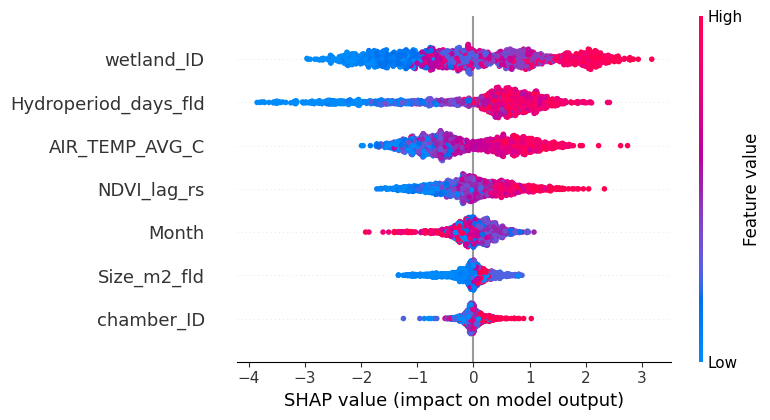

In [56]:
# train a model that uses air temp instead of soil temp, no water depth, WFPS, land cover
X_air = df_PT[['Hydroperiod_days_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'Month', 'chamber_ID', 'wetland_ID', 'AIR_TEMP_AVG_C']]
y_air = df_PT['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

x_air_categorical = X_air.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_air_numerical = X_air.select_dtypes(exclude = ['object'])

x_air = pd.concat([x_air_categorical, x_air_numerical], axis = 1)

# print(x_pos)
print(x_air.info())

X_air_train, X_air_test, y_air_train, y_air_test = train_test_split(x_air, y_air, test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_air = RandomForestRegressor(oob_score = True)

regressor_air.fit(X_air_train, y_air_train)

predictions_air = regressor_air.predict(X_air_test)
print(f'R-squared, no max depth, using air temp: {r2_score(y_air_test, predictions_air)}')

# SHAP plot
explainer_air = shap.Explainer(regressor_air)

shap_values_air = explainer_air.shap_values(X_air_test)
shap.summary_plot(shap_values_air, X_air_test)

In [124]:
df_PT

chamber_ID       Date GS_Interval_fld  Hydroperiod_days_fld   LAB_ID  \
0              1  5/18/2009           Early                 156.0      1.3   
1              1   6/3/2009           Early                 156.0    153.3   
2              1  6/18/2009           Early                 156.0    325.3   
3              1  7/16/2009           Early                 156.0    669.0   
4              1  7/28/2009           Early                 156.0    841.5   
...          ...        ...             ...                   ...      ...   
4937           5  5/22/2015           Early                   0.0  34216.0   
4938           5   6/4/2015           Early                   0.0  34485.0   
4939           5   7/1/2015           Early                   0.0  34977.0   
4940           5  7/16/2015           Early                   0.0  35223.0   
4941           5  7/30/2015            Late                   0.0    960.7   

     Land_Cover_fld  methane_flux_log_mg_m2_hr  NDVI_lag_rs  NDVI_rs  \
0             Grass                  -2.383779         0.03     0.03   
1             Grass                  -1.714138         0.03     0.11   
2             Grass                  -1.042693         0.11     0.27   
3             Grass                  -1.905919         0.27     0.39   
4             Grass                  -1.468251         0.39     0.39   
...             ...                        ...          ...      ...   
4937          Grass                  -6.371262         0.37     0.45   
4938          Grass                  -2.653150         0.45     0.53   
4939          Grass                  -1.672548         0.53     0.59   
4940          Grass                  -1.952675         0.59     0.66   
4941          Grass                  -4.431536         0.66     0.67   

      Size_m2_fld  ...  Wetland_Chamber  wetland_ID  WFPS_lag_pcnt_fld  \
0         58200.0  ...             P1_1          P1         100.000000   
1         58200.0  ...             P1_1          P1         100.000000   
2         58200.0  ...             P1_1          P1         100.000000   
3         58200.0  ...             P1_1          P1         100.000000   
4         58200.0  ...             P1_1          P1         100.000000   
...           ...  ...              ...         ...                ...   
4937      11500.0  ...             T9_5          T9          60.498386   
4938      11500.0  ...             T9_5          T9          62.698328   
4939      11500.0  ...             T9_5          T9          51.855760   
4940      11500.0  ...             T9_5          T9          69.769568   
4941      11500.0  ...             T9_5          T9          58.769861   

     WFPS_pcnt_fld Date Object  Month  Year AIR_TMIN_C  AIR_TMAX_C  \
0       100.000000  2009-05-18      5  2009   3.766267   24.065105   
1       100.000000  2009-06-03      6  2009   2.925106   20.843944   
2       100.000000  2009-06-18      6  2009  15.052324   22.205106   
3       100.000000  2009-07-16      7  2009   6.510458   19.323943   
4       100.000000  2009-07-28      7  2009   9.216972   22.693944   
...            ...         ...    ...   ...        ...         ...   
4937     62.698328  2015-05-22      5  2015   6.180000   22.770000   
4938     51.855760  2015-06-04      6  2015   8.670000   20.370001   
4939     69.769568  2015-07-01      7  2015  15.710000   24.870001   
4940     58.769861  2015-07-16      7  2015  16.959999   26.180000   
4941     38.813250  2015-07-30      7  2015  12.380000   27.670000   

      AIR_TEMP_AVG_C  
0          13.915686  
1          11.884525  
2          18.628715  
3          12.917200  
4          15.955458  
...              ...  
4937       14.475000  
4938       14.520000  
4939       20.290000  
4940       21.570000  
4941       20.025000  

[4942 rows x 23 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4942 entries, 0 to 4941
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hydroperiod_days_fld  4942 non-null   float64
 1   NDVI_lag_rs           4942 non-null   float64
 2   Size_m2_fld           4942 non-null   float64
 3   Month                 4942 non-null   int32  
 4   AIR_TEMP_AVG_C        4942 non-null   float64
dtypes: float64(4), int32(1)
memory usage: 173.9 KB
None
R-squared, no max depth, using air temp, no ID: 0.6067694446503256


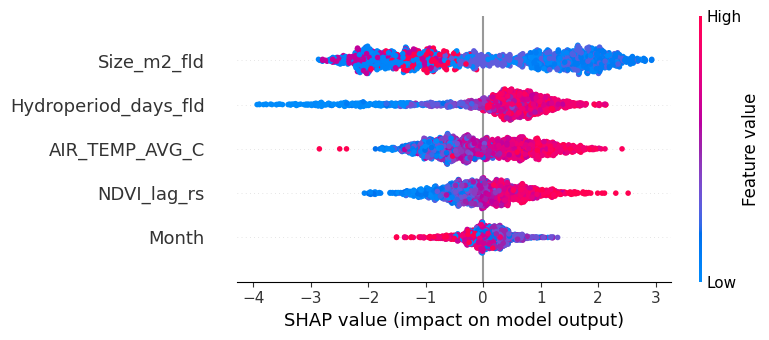

In [58]:
# okay now remove ID features
# train a model that uses air temp instead of soil temp, no water depth, WFPS, land cover
X_air_noID = df_PT[['Hydroperiod_days_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'Month', 'AIR_TEMP_AVG_C']]
y_air_noID = df_PT['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

#x_air_noID_categorical = X_air_noID.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_air_noID_numerical = X_air_noID.select_dtypes(exclude = ['object'])

x_air_noID = pd.concat([x_air_noID_numerical], axis = 1)

# print(x_pos)
print(x_air_noID.info())

X_air_noID_train, X_air_noID_test, y_air_noID_train, y_air_noID_test = train_test_split(x_air_noID, y_air_noID, test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_air_noID = RandomForestRegressor(oob_score = True)

regressor_air_noID.fit(X_air_noID_train, y_air_noID_train)

predictions_air_noID = regressor_air_noID.predict(X_air_noID_test)
print(f'R-squared, no max depth, using air temp, no ID: {r2_score(y_air_noID_test, predictions_air_noID)}')

# SHAP plot
explainer_air_noID = shap.Explainer(regressor_air_noID)

shap_values_air_noID = explainer_air_noID.shap_values(X_air_noID_test)
shap.summary_plot(shap_values_air_noID, X_air_noID_test)

In [59]:
df_PT['Size_m2_fld'].unique()

array([58200.,  6100., 91900., 28000., 30902., 25100.,  5916.,  5500.,
        2300.,  1600.,  4000., 10300., 11500.])

In [148]:
def all_pdps(model, X_test):
    for i in range(len(X_test.columns)):
        feature_index = i
        colName = X_test.columns[feature_index]

        # print(colName)

        fig, ax = plt.subplots(figsize = (6, 4))
        PartialDependenceDisplay.from_estimator(model, X_test, [feature_index], ax = ax, kind = "average")

        
        # add histogram
        ax_hist = ax.twinx()
        # ax_hist.hist(X_noID_m_test[:, feature[0]], bins = 10, alpha = 0.3, color = 'blue', edgecolor = 'black')
        ax_hist.hist(X_test[colName].values, bins = 30, alpha = 0.3, color = 'grey', edgecolor = 'black')
        ax_hist.set_ylabel("Frequency", color = 'black')
        
        # plt.ylabel("Partial Dependence; Change in Methane Flux")
        plt.title("Partial Dependence Plot with Histogram")
        plt.tight_layout()
        plt.show()

In [256]:
# import matplotlib.pyplot as plt
# from sklearn.inspection import plot_partial_dependence
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification

def all_pdps2(model, X_test):
    for i in range(len(X_test.columns)):
        feature_index = i
        colName = X_test.columns[feature_index]

        # Create the partial dependence plot
        fig, ax = plt.subplots(figsize=(6, 4))
        pdp_display = PartialDependenceDisplay.from_estimator(
            model, X_test, [feature_index], 
            #feature_names=colName, 
            ax=ax,
            kind='average', # or 'individual'
            # hist_kw={'density': True} # Example for histogram
        )
        # Change the y-axis label of the specific subplot
        # pdp_display.axes_ is a 2D array, access the relevant subplot
        pdp_display.axes_[0][0].set_ylabel("Log Methane Flux Partial Dependency")

        # add histogram
        ax_hist = ax.twinx()
        # ax_hist.hist(X_noID_m_test[:, feature[0]], bins = 10, alpha = 0.3, color = 'blue', edgecolor = 'black')

        # try to do log scale for size
        if colName == 'Size_m2_fld':
            ax_hist.hist(np.log(X_test[colName].values), bins = 30, alpha = 0.3, color = 'grey', edgecolor = 'black')
            ax_hist.set_xlabel("Log(Size_m2_fld)") # NOT WORKING
            # Access partial dependence for the feature (index 0)
            # feature_values = pdp_display.pd_results_[0]['values'][0]
            # feature_values = pdp_display.pd_results_[0]['average'][0]
        else:
            ax_hist.hist(X_test[colName].values, bins = 30, alpha = 0.3, color = 'grey', edgecolor = 'black')
        
        ax_hist.set_ylabel("Frequency", color = 'black')
        
    
        plt.tight_layout()
        plt.show()
        

In [254]:
from sklearn.inspection import partial_dependence

def size_pdp(model, X_test):
    colName = 'Size_m2_fld'
    feature_index = X_test.columns.get_loc(colName)

    # Create the partial dependence plot
    fig, ax = plt.subplots(figsize=(6, 4))

    # get the partial dependence values
    pd_results = partial_dependence(model, X_test, features=[feature_index], kind="average", grid_resolution=100)

    grid_values = pd_results['grid_values']

    log_pd_results = {'grid_values': np.log(grid_values), 'average': pd_results['average']}

    log_grid = log_pd_results['grid_values'][0]
    avg = log_pd_results['average'][0]

    ax.plot(log_grid, avg)
    # plt.plot(log_grid, avg)

    print(log_grid)
    print(np.log(X_test[colName].values))
    print(max(grid_values[0]))
    
    # add histogram
    ax_hist = ax.twinx()

    print(max(X_test[colName].values))
    # ax_hist.hist(log_grid, bins = 30, alpha = 0.3, color = 'grey', edgecolor = 'black')
    ax_hist.hist(np.log(X_test[colName].values), bins = 30, alpha = 0.3, color = 'grey', edgecolor = 'black')
    ax_hist.set_ylabel("Frequency", color = 'black')

    ax.set_xlabel('Log(Size_m2_fld)')

    # ax[0][0].set_ylabel("Log Methane Flux Partial Dependency")
    plt.show()


[ 7.37775891  7.68327346  7.91696582  8.10625861  8.26535915  8.40258692
  8.52323551  8.63088256  8.72805967  8.81662416  8.89797915  8.97321058
  9.04317609  9.10856489  9.16993916  9.22776346  9.2824261   9.33425496
  9.38352945  9.43048955  9.47534296  9.51827061  9.55943107  9.59896412
  9.63699356  9.67362959  9.70897072  9.74310538  9.77611321  9.80806626
  9.83902984  9.8690634   9.89822118  9.92655283  9.95410385  9.98091612
 10.00702823 10.03247581 10.05729185 10.08150694 10.10514949 10.12824596
 10.150821   10.17289764 10.19449742 10.21564048 10.23634576 10.25663102
 10.27651294 10.29600728 10.31512883 10.33389161 10.35230882 10.37039295
 10.38815586 10.40560874 10.42276223 10.43962644 10.45621096 10.47252491
 10.48857698 10.50437545 10.51992821 10.53524277 10.55032634 10.56518576
 10.57982761 10.59425817 10.60848345 10.6225092  10.63634095 10.64998399
 10.6634434  10.67672406 10.68983065 10.70276768 10.71553947 10.72815021
 10.74060389 10.75290438 10.7650554  10.77706055 10

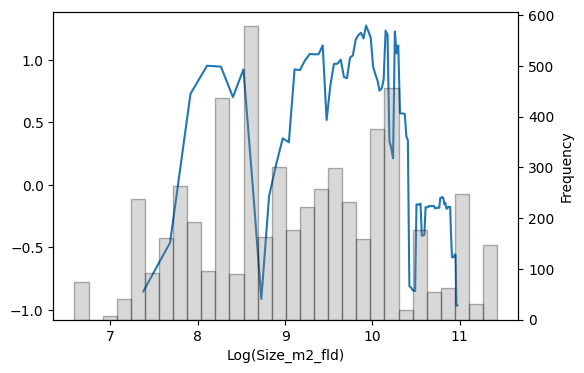

In [255]:
size_pdp(regressor_noyr_wfps_water, X_noyr_wfps_water_test)

In [234]:
np.log(10)

np.float64(2.302585092994046)

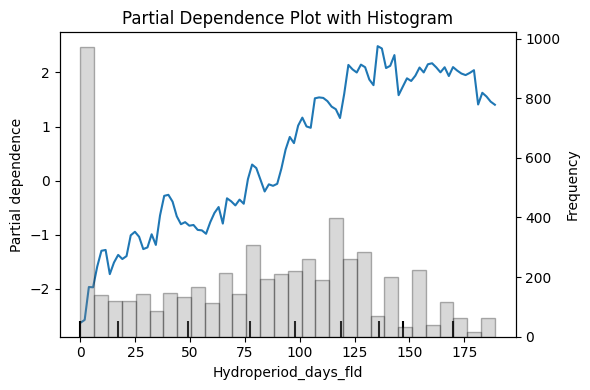

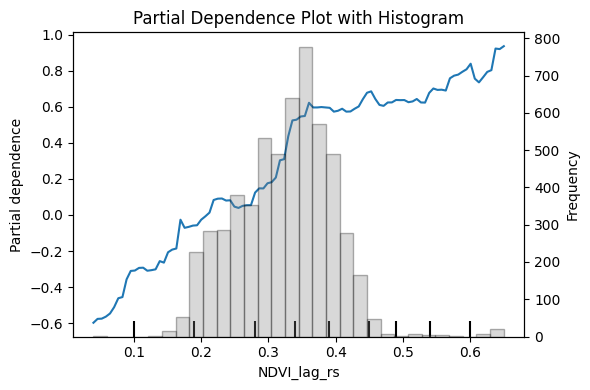

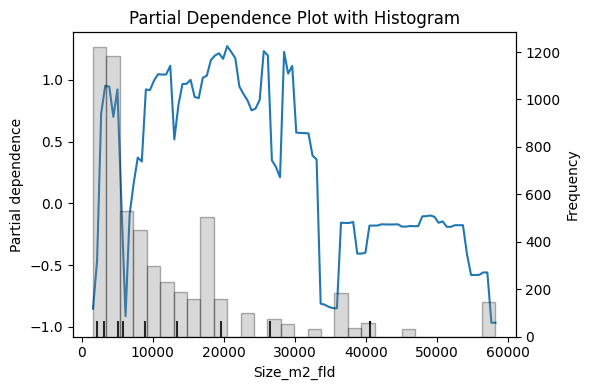

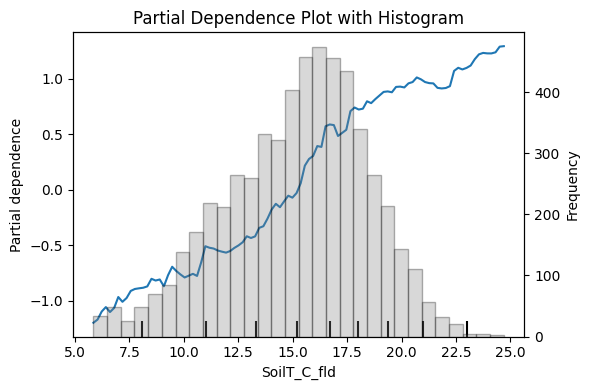

/Users/lauralayton/.pyenv/versions/venv3.12.11/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


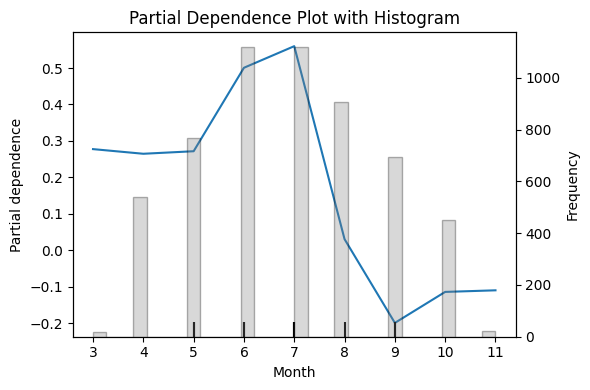

In [235]:
all_pdps(regressor_noyr_wfps_water, X_noyr_wfps_water_test)

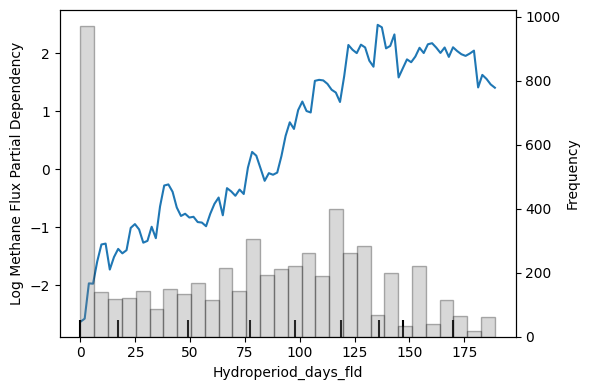

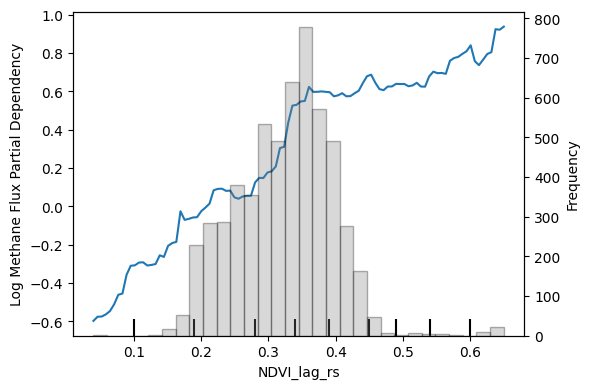

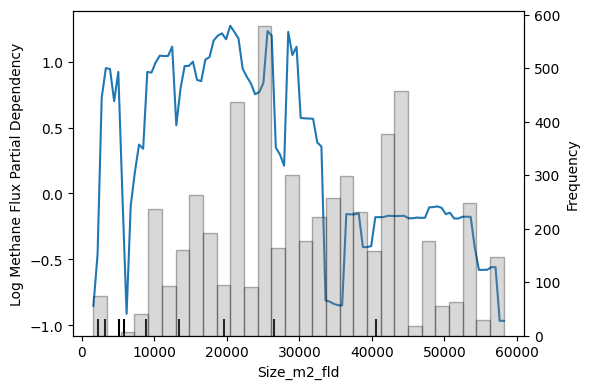

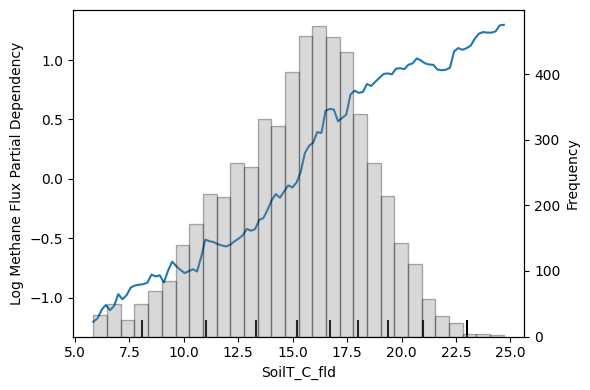

/Users/lauralayton/.pyenv/versions/venv3.12.11/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


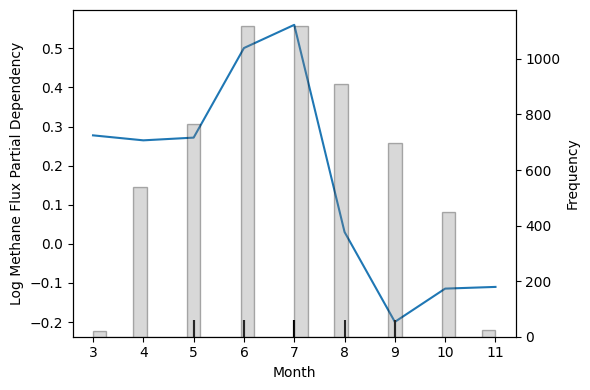

In [257]:
all_pdps2(regressor_noyr_wfps_water, X_noyr_wfps_water_test)

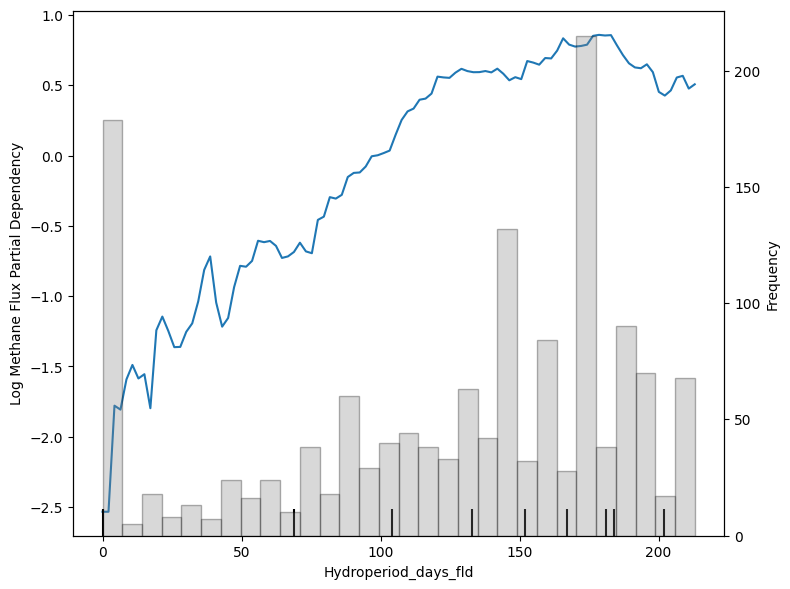

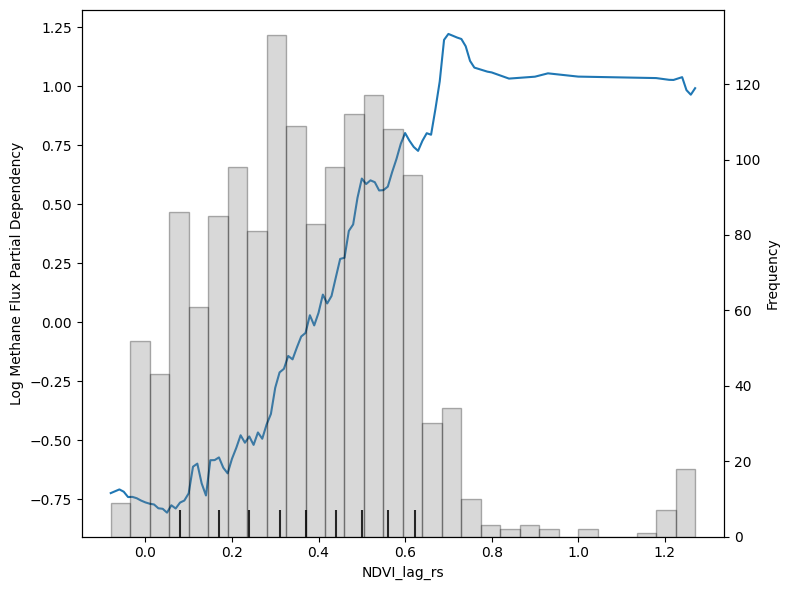

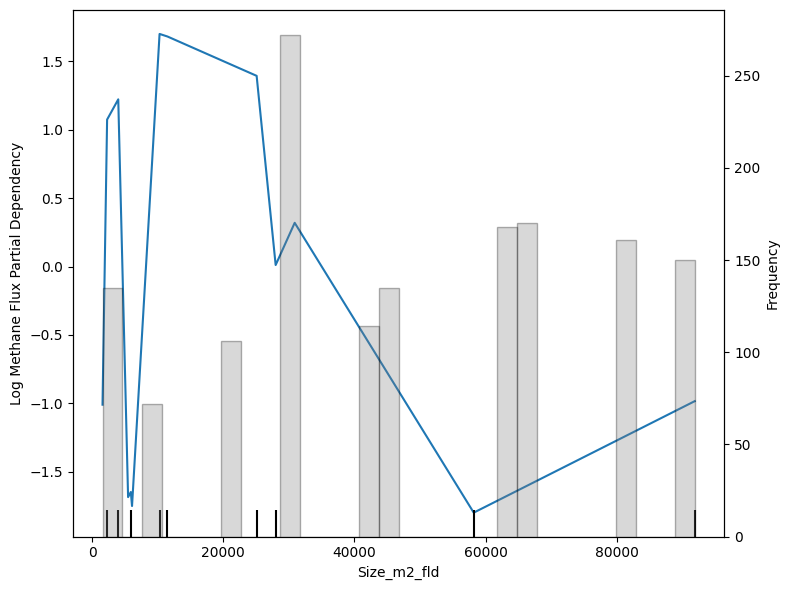

/Users/lauralayton/.pyenv/versions/venv3.12.11/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 3 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


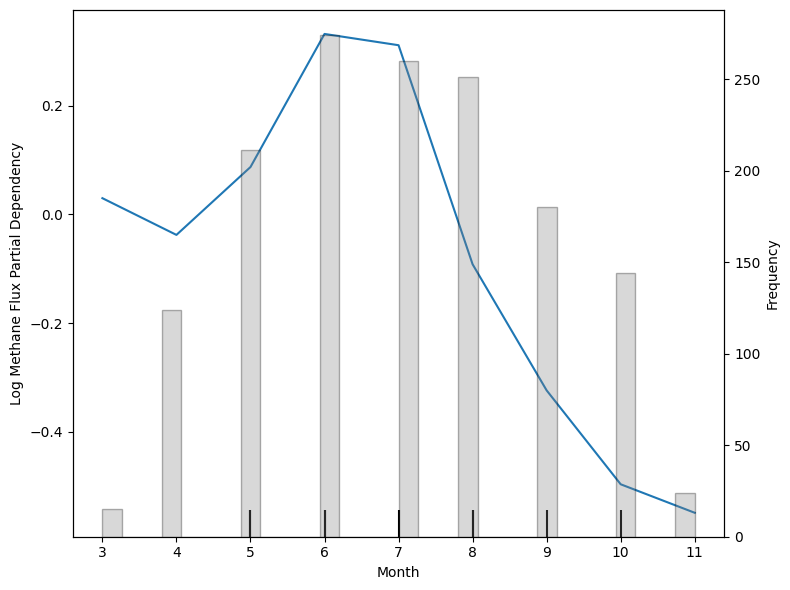

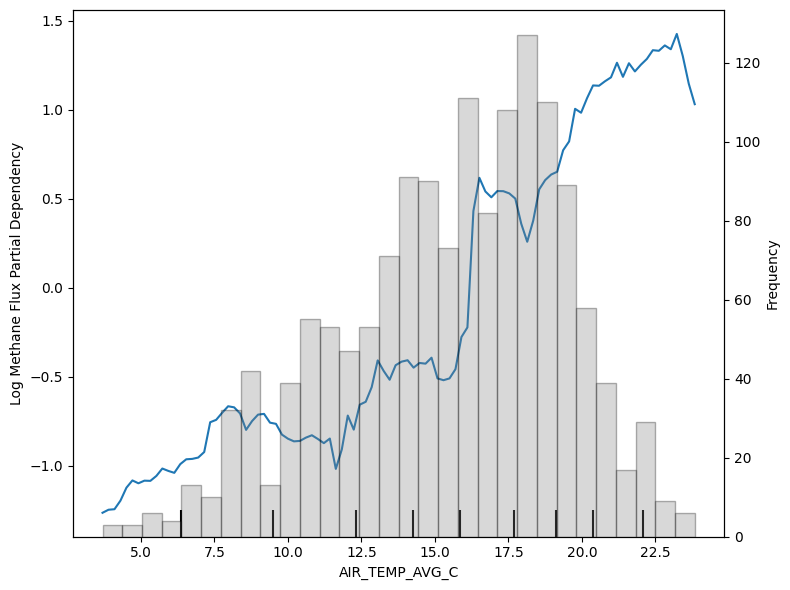

In [191]:
all_pdps2(regressor_air_noID, X_air_noID_test)

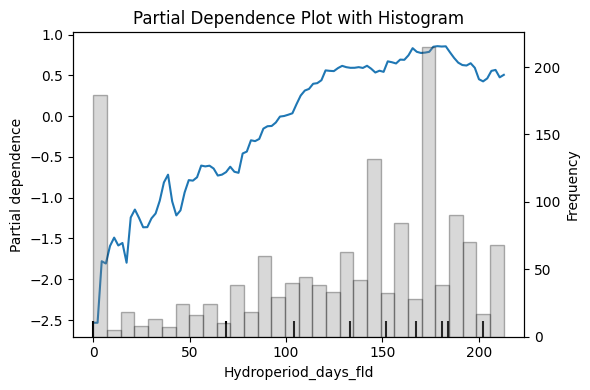

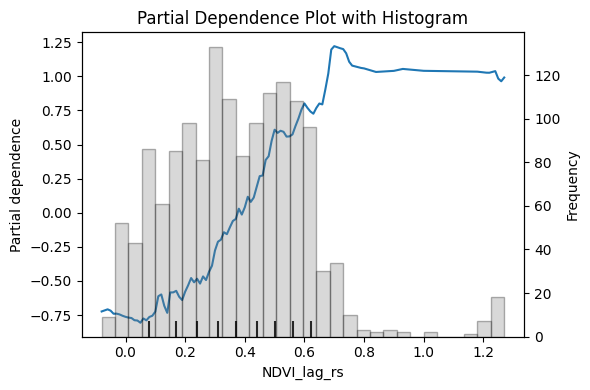

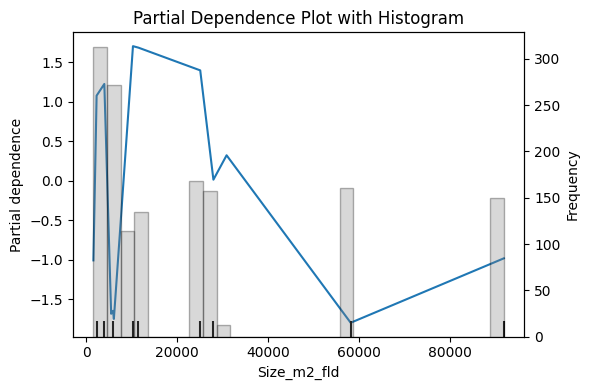

/Users/lauralayton/.pyenv/versions/venv3.12.11/lib/python3.12/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 3 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


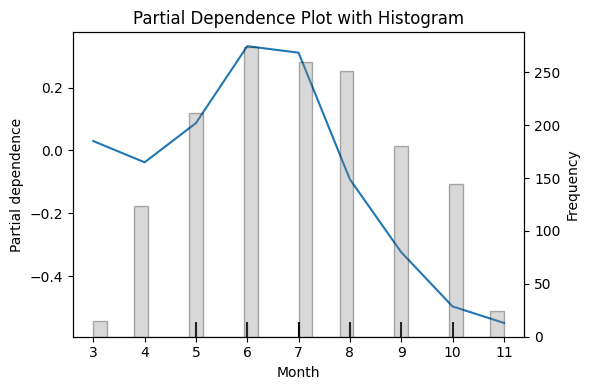

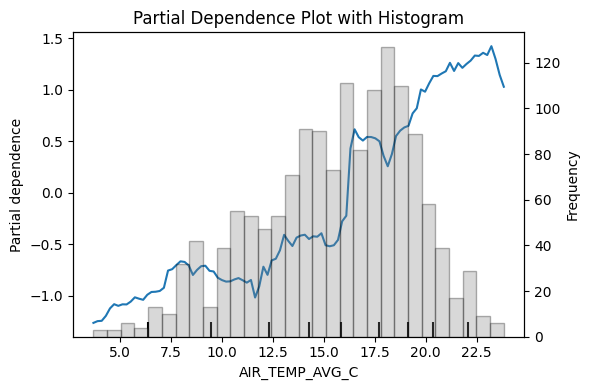

In [149]:
all_pdps(regressor_air_noID, X_air_noID_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4942 entries, 0 to 4941
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hydroperiod_days_fld  4942 non-null   float64
 1   NDVI_lag_rs           4942 non-null   float64
 2   Month                 4942 non-null   int32  
 3   AIR_TEMP_AVG_C        4942 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 135.3 KB
None
R-squared, no max depth, using air temp, no ID, no size: 0.48409310456801324


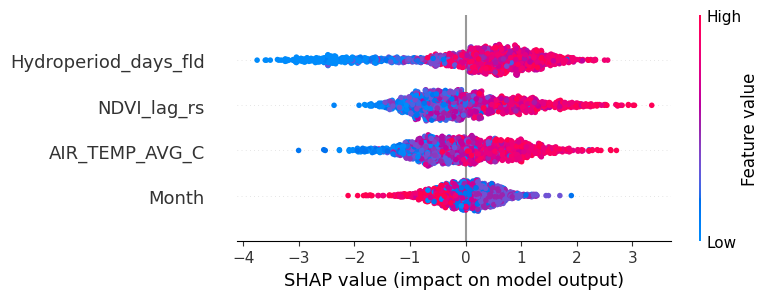

In [63]:
# try a model with no size
X_air_noID_nosize = df_PT[['Hydroperiod_days_fld', 'NDVI_lag_rs', 'Month', 'AIR_TEMP_AVG_C']]
y_air_noID_nosize = df_PT['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

#x_air_noID_categorical = X_air_noID.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_air_noID_nosize_numerical = X_air_noID_nosize.select_dtypes(exclude = ['object'])

x_air_noID_nosize = pd.concat([x_air_noID_nosize_numerical], axis = 1)

# print(x_pos)
print(x_air_noID_nosize.info())

X_air_noID_nosize_train, X_air_noID_nosize_test, y_air_noID_nosize_train, y_air_noID_nosize_test = train_test_split(x_air_noID_nosize,
                                                                                                                    y_air_noID_nosize, 
                                                                                                                    test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_air_noID_nosize = RandomForestRegressor(oob_score = True)

regressor_air_noID_nosize.fit(X_air_noID_nosize_train, y_air_noID_nosize_train)

predictions_air_noID_nosize = regressor_air_noID_nosize.predict(X_air_noID_nosize_test)
print(f'R-squared, no max depth, using air temp, no ID, no size: {r2_score(y_air_noID_nosize_test, predictions_air_noID_nosize)}')

# SHAP plot
explainer_air_noID_nosize = shap.Explainer(regressor_air_noID_nosize)

shap_values_air_noID_nosize = explainer_air_noID_nosize.shap_values(X_air_noID_nosize_test)
shap.summary_plot(shap_values_air_noID_nosize, X_air_noID_nosize_test)

In [72]:
# wetland names and sizes
wetlands_included = df_PT['wetland_ID'].unique().tolist()
sizes = []

for wetland in wetlands_included:
    df_subset = df_PT[(df_PT['wetland_ID'] == wetland)]
    # print( df_subset['Size_m2_fld'])
    size = df_subset['Size_m2_fld'].unique().tolist()[0]
    sizes.append([wetland, size])

In [73]:
sizes

[['P1', 58200.0],
 ['P3', 6100.0],
 ['P4', 91900.0],
 ['P6', 28000.0],
 ['P7', 30902.0],
 ['P8', 25100.0],
 ['T2', 5916.0],
 ['T3', 5500.0],
 ['T5', 2300.0],
 ['T6', 1600.0],
 ['T7', 4000.0],
 ['T8', 10300.0],
 ['T9', 11500.0]]

In [74]:
GSW_df = pd.read_csv('/Users/lauralayton/Downloads/GSW_Data.csv')

In [75]:
GSW_PT = GSW_df[GSW_df['Wetland_ID'].isin(available_wetlands)]

In [77]:
GSW_PT_bansal = GSW_df[GSW_df['Wetland_ID'].isin(df['wetland_ID'].unique().tolist())]

In [90]:
GSW_PT_bansal

CELL_AREA_M2        DATE        LAT       LONG Wetland_ID  water  \
479       611.314190  2009-01-01  47.097008 -99.099223         P1      0   
480       611.314190  2009-01-01  47.097008 -99.098953         P1      0   
481       611.314190  2009-01-01  47.097008 -99.098684         P1      0   
482       611.314190  2009-01-01  47.097008 -99.098414         P1      0   
483       611.311096  2009-01-01  47.097278 -99.100301         P1      0   
...              ...         ...        ...        ...        ...    ...   
120949    611.301814  2016-12-01  47.098086 -99.094911         T5      0   
120950    611.301814  2016-12-01  47.098086 -99.094641         T5      0   
120951    611.298721  2016-12-01  47.098356 -99.095180         T5      0   
120952    611.298721  2016-12-01  47.098356 -99.094911         T5      0   
120953    611.298721  2016-12-01  47.098356 -99.094641         T5      0   

        NO_DATA_IND  WATER_IND  HYDROPERIOD  MONTHS_NO_DATA  ...  \
479               1          0          0.0             6.0  ...   
480               1          0          0.0             6.0  ...   
481               1          0          0.0             6.0  ...   
482               1          0          0.0             6.0  ...   
483               1          0          0.0             6.0  ...   
...             ...        ...          ...             ...  ...   
120949            1          0          0.0             5.0  ...   
120950            1          0          0.0             5.0  ...   
120951            1          0          0.0             5.0  ...   
120952            1          0          0.0             5.0  ...   
120953            1          0          0.0             5.0  ...   

        WETLAND SIZE  WETLAND SIZE M2  Month  Size_m2_fld  AIR_TMIN_C  \
479              NaN              NaN      1      58200.0  -24.739542   
480              NaN              NaN      1      58200.0  -24.739542   
481              NaN              NaN      1      58200.0  -24.739542   
482              NaN              NaN      1      58200.0  -24.739542   
483              NaN              NaN      1      58200.0  -24.739542   
...              ...              ...    ...          ...         ...   
120949           NaN              NaN     12       2300.0   -3.690000   
120950           NaN              NaN     12       2300.0   -3.690000   
120951           NaN              NaN     12       2300.0   -3.690000   
120952           NaN              NaN     12       2300.0   -3.690000   
120953           NaN              NaN     12       2300.0   -3.690000   

        AIR_TMAX_C  AIR_TEMP_AVG_C  Year  MEAN NDVI LAG  Hydroperiod_days_fld  
479      -7.779542      -16.259542  2009      -0.082529                   0.0  
480      -7.779542      -16.259542  2009      -0.082529                   0.0  
481      -7.779542      -16.259542  2009      -0.082529                   0.0  
482      -7.779542      -16.259542  2009      -0.082529                   0.0  
483      -7.779542      -16.259542  2009      -0.082529                   0.0  
...            ...             ...   ...            ...                   ...  
120949   -2.000000       -2.845000  2016       0.164063                   0.0  
120950   -2.000000       -2.845000  2016       0.164063                   0.0  
120951   -2.000000       -2.845000  2016       0.164063                   0.0  
120952   -2.000000       -2.845000  2016       0.164063                   0.0  
120953   -2.000000       -2.845000  2016       0.164063                   0.0  

[59232 rows x 21 columns]

In [86]:
import math

GSW_PT_bansal['Hydroperiod_days_fld'] = GSW_PT_bansal['HYDROPERIOD']


GSW_PT_bansal_nonan = GSW_PT_bansal[(GSW_PT_bansal['MEAN NDVI LAG'].notnull()) & 
    (GSW_PT_bansal['AIR_TEMP_AVG_C'].notnull()) & 
    (GSW_PT_bansal['Size_m2_fld'].notnull()) & 
    (GSW_PT_bansal['Hydroperiod_days_fld'].notnull()) & 
    (GSW_PT_bansal['Month'].notnull())]

/var/folders/zn/fbx3h9w10m1ff_g3y0gg08lw0000gq/T/ipykernel_98437/1309212505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  GSW_PT_bansal['Hydroperiod_days_fld'] = GSW_PT_bansal['HYDROPERIOD']


In [88]:
GSW_PT_bansal['Hydroperiod_days_fld'].unique()

array([  0. , 122. , 183. , 152.5,  61. ,  30.5,  91.5, 213.5, 244. ])

In [92]:
GSW_PT_bansal_nonan['NDVI_lag_rs'] = GSW_PT_bansal_nonan['MEAN NDVI LAG']

In [94]:
X_gsw = GSW_PT_bansal_nonan[['Hydroperiod_days_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'Month', 'AIR_TEMP_AVG_C']]

predictions_on_gsw = regressor_air_noID.predict(X_gsw)


array([-4.19638616, -4.19638616, -4.19638616, ..., -3.8395773 ,
       -3.8395773 , -3.8395773 ], shape=(59232,))

In [96]:
GSW_w_pred = GSW_PT_bansal_nonan
GSW_w_pred['predictions'] = predictions_on_gsw

In [97]:
GSW_w_pred

CELL_AREA_M2        DATE        LAT       LONG Wetland_ID  water  \
479       611.314190  2009-01-01  47.097008 -99.099223         P1      0   
480       611.314190  2009-01-01  47.097008 -99.098953         P1      0   
481       611.314190  2009-01-01  47.097008 -99.098684         P1      0   
482       611.314190  2009-01-01  47.097008 -99.098414         P1      0   
483       611.311096  2009-01-01  47.097278 -99.100301         P1      0   
...              ...         ...        ...        ...        ...    ...   
120949    611.301814  2016-12-01  47.098086 -99.094911         T5      0   
120950    611.301814  2016-12-01  47.098086 -99.094641         T5      0   
120951    611.298721  2016-12-01  47.098356 -99.095180         T5      0   
120952    611.298721  2016-12-01  47.098356 -99.094911         T5      0   
120953    611.298721  2016-12-01  47.098356 -99.094641         T5      0   

        NO_DATA_IND  WATER_IND  HYDROPERIOD  MONTHS_NO_DATA  ...  Month  \
479               1          0          0.0             6.0  ...      1   
480               1          0          0.0             6.0  ...      1   
481               1          0          0.0             6.0  ...      1   
482               1          0          0.0             6.0  ...      1   
483               1          0          0.0             6.0  ...      1   
...             ...        ...          ...             ...  ...    ...   
120949            1          0          0.0             5.0  ...     12   
120950            1          0          0.0             5.0  ...     12   
120951            1          0          0.0             5.0  ...     12   
120952            1          0          0.0             5.0  ...     12   
120953            1          0          0.0             5.0  ...     12   

        Size_m2_fld  AIR_TMIN_C  AIR_TMAX_C  AIR_TEMP_AVG_C  Year  \
479         58200.0  -24.739542   -7.779542      -16.259542  2009   
480         58200.0  -24.739542   -7.779542      -16.259542  2009   
481         58200.0  -24.739542   -7.779542      -16.259542  2009   
482         58200.0  -24.739542   -7.779542      -16.259542  2009   
483         58200.0  -24.739542   -7.779542      -16.259542  2009   
...             ...         ...         ...             ...   ...   
120949       2300.0   -3.690000   -2.000000       -2.845000  2016   
120950       2300.0   -3.690000   -2.000000       -2.845000  2016   
120951       2300.0   -3.690000   -2.000000       -2.845000  2016   
120952       2300.0   -3.690000   -2.000000       -2.845000  2016   
120953       2300.0   -3.690000   -2.000000       -2.845000  2016   

        MEAN NDVI LAG  Hydroperiod_days_fld  NDVI_lag_rs  predictions  
479         -0.082529                   0.0    -0.082529    -4.196386  
480         -0.082529                   0.0    -0.082529    -4.196386  
481         -0.082529                   0.0    -0.082529    -4.196386  
482         -0.082529                   0.0    -0.082529    -4.196386  
483         -0.082529                   0.0    -0.082529    -4.196386  
...               ...                   ...          ...          ...  
120949       0.164063                   0.0     0.164063    -3.839577  
120950       0.164063                   0.0     0.164063    -3.839577  
120951       0.164063                   0.0     0.164063    -3.839577  
120952       0.164063                   0.0     0.164063    -3.839577  
120953       0.164063                   0.0     0.164063    -3.839577  

[59232 rows x 23 columns]

In [98]:
import os
base_dir = '/Users/lauralayton/Downloads/'
csv_path = os.path.join(base_dir, "GSW_Data_w_pred.csv")
GSW_w_pred.to_csv(csv_path, index=False)

<Axes: ylabel='Frequency'>

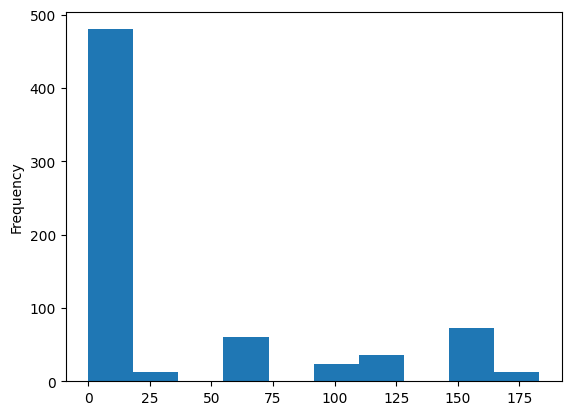

In [114]:
GSW_w_pred[(GSW_w_pred['Wetland_ID'] == 'P8') &
    (GSW_w_pred['Year'] == 2009)]['HYDROPERIOD'].plot.hist()

<Axes: ylabel='Frequency'>

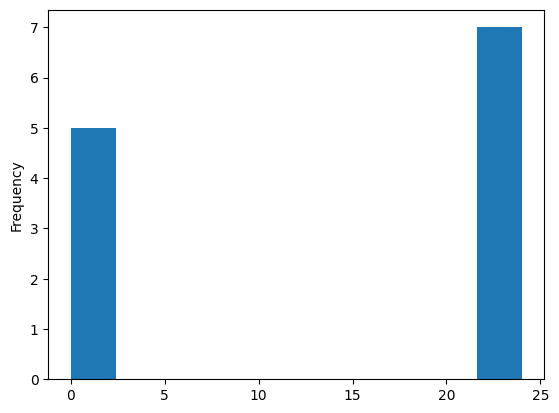

In [116]:
df_PT[(df_PT['wetland_ID'] == 'T9') & (df_PT['Year'] == 2016)]['Hydroperiod_days_fld'].plot.hist()

In [117]:
df_PT[(df_PT['wetland_ID'] == 'T9') & (df_PT['Year'] == 2016)][['Hydroperiod_days_fld', 'chamber_ID']]

Hydroperiod_days_fld  chamber_ID
4572                  24.0           1
4573                  24.0           1
4574                  24.0           1
4575                  24.0           1
4576                  24.0           1
4577                  24.0           1
4578                  24.0           1
4674                   0.0           2
4675                   0.0           2
4676                   0.0           2
4677                   0.0           2
4678                   0.0           2

In [120]:
test_date = convert('2016-07-01')
GSW_w_pred[GSW_w_pred['DATE'] == test_date]

Empty DataFrame
Columns: [CELL_AREA_M2, DATE, LAT, LONG, Wetland_ID, water, NO_DATA_IND, WATER_IND, HYDROPERIOD, MONTHS_NO_DATA, MEAN NDVI, WETLAND SIZE, WETLAND SIZE M2, Month, Size_m2_fld, AIR_TMIN_C, AIR_TMAX_C, AIR_TEMP_AVG_C, Year, MEAN NDVI LAG, Hydroperiod_days_fld, NDVI_lag_rs, predictions]
Index: []

[0 rows x 23 columns]

In [122]:
GSW_w_pred[(GSW_w_pred['Year'] == 2016) & 
    (GSW_w_pred['Month'] == 7)]

CELL_AREA_M2        DATE        LAT       LONG Wetland_ID  water  \
113879    611.314190  2016-07-01  47.097008 -99.099223         P1      1   
113880    611.314190  2016-07-01  47.097008 -99.098953         P1      1   
113881    611.314190  2016-07-01  47.097008 -99.098684         P1      1   
113882    611.314190  2016-07-01  47.097008 -99.098414         P1      1   
113883    611.311096  2016-07-01  47.097278 -99.100301         P1      1   
...              ...         ...        ...        ...        ...    ...   
114649    611.301814  2016-07-01  47.098086 -99.094911         T5      1   
114650    611.301814  2016-07-01  47.098086 -99.094641         T5      1   
114651    611.298721  2016-07-01  47.098356 -99.095180         T5      1   
114652    611.298721  2016-07-01  47.098356 -99.094911         T5      1   
114653    611.298721  2016-07-01  47.098356 -99.094641         T5      1   

        NO_DATA_IND  WATER_IND  HYDROPERIOD  MONTHS_NO_DATA  ...  Month  \
113879            0          0          0.0             5.0  ...      7   
113880            0          0          0.0             5.0  ...      7   
113881            0          0          0.0             5.0  ...      7   
113882            0          0          0.0             5.0  ...      7   
113883            0          0          0.0             5.0  ...      7   
...             ...        ...          ...             ...  ...    ...   
114649            0          0          0.0             5.0  ...      7   
114650            0          0          0.0             5.0  ...      7   
114651            0          0          0.0             5.0  ...      7   
114652            0          0          0.0             5.0  ...      7   
114653            0          0          0.0             5.0  ...      7   

        Size_m2_fld  AIR_TMIN_C  AIR_TMAX_C  AIR_TEMP_AVG_C  Year  \
113879      58200.0    6.453944   21.885106       14.169525  2016   
113880      58200.0    6.453944   21.885106       14.169525  2016   
113881      58200.0    6.453944   21.885106       14.169525  2016   
113882      58200.0    6.453944   21.885106       14.169525  2016   
113883      58200.0    6.453944   21.885106       14.169525  2016   
...             ...         ...         ...             ...   ...   
114649       2300.0    6.440000   21.870001       14.155000  2016   
114650       2300.0    6.440000   21.870001       14.155000  2016   
114651       2300.0    6.440000   21.870001       14.155000  2016   
114652       2300.0    6.440000   21.870001       14.155000  2016   
114653       2300.0    6.440000   21.870001       14.155000  2016   

        MEAN NDVI LAG  Hydroperiod_days_fld  NDVI_lag_rs  predictions  
113879       0.058003                   0.0     0.058003    -2.612626  
113880       0.058003                   0.0     0.058003    -2.612626  
113881       0.058003                   0.0     0.058003    -2.612626  
113882       0.058003                   0.0     0.058003    -2.612626  
113883       0.058003                   0.0     0.058003    -2.612626  
...               ...                   ...          ...          ...  
114649       0.286357                   0.0     0.286357    -2.231185  
114650       0.286357                   0.0     0.286357    -2.231185  
114651       0.286357                   0.0     0.286357    -2.231185  
114652       0.286357                   0.0     0.286357    -2.231185  
114653       0.286357                   0.0     0.286357    -2.231185  

[617 rows x 23 columns]

In [123]:
GSW_w_pred['DATE']

479       2009-01-01
480       2009-01-01
481       2009-01-01
482       2009-01-01
483       2009-01-01
             ...    
120949    2016-12-01
120950    2016-12-01
120951    2016-12-01
120952    2016-12-01
120953    2016-12-01
Name: DATE, Length: 59232, dtype: object

<Axes: ylabel='Frequency'>

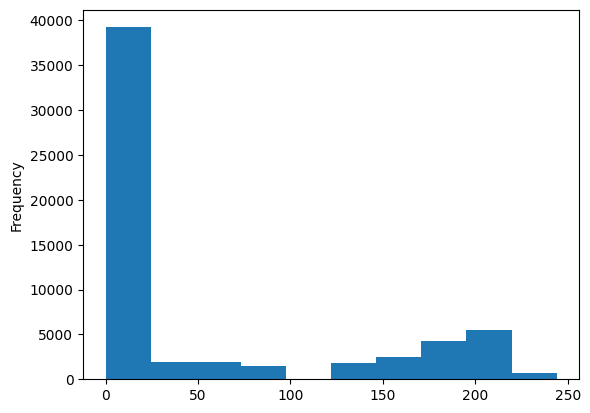

In [125]:
GSW_w_pred['HYDROPERIOD'].plot.hist()

In [260]:
# predict on training set
predictions_on_train_noyr_wfps_water = regressor_noyr_wfps_water.predict(X_noyr_wfps_water_train)

# actually maybe I just add 2 columns to the df, one for train vs test indicator and one for model prediction
# regressor_noyr_wfps_water
train_index = X_noyr_wfps_water_train.index
test_index = X_noyr_wfps_water_test.index


def test_ind(index):
    if index in train_index:
        return 0
    else:
        return 1

def grab_model_pred(index):
    if index in train_index:
        ind_in_train = train_index.tolist().index(index)
        model_pred = predictions_on_train_noyr_wfps_water[ind_in_train]
        return model_pred
    else:
        ind_in_test = test_index.tolist().index(index)
        model_pred = predictions_noyr_wfps_water[ind_in_test]
        return model_pred


df_full['TEST_IND'] = df_full.index.map(test_ind)
df_full['Model Prediction'] = df_full.index.map(grab_model_pred)

In [265]:
def days_since(date1, date2):
    return (date2 - date1).days
    
jan1_2009 = datetime.datetime(year=2009, month=1, day=1)
df_full['Days Since Jan 1, 2009'] = df_full.apply(lambda x: days_since(jan1_2009, x['Date Object']), axis = 1)

In [266]:
def compare_model_and_data(wetland, chamber):
    # create a list containing all indices in the original whole data set corresponding
    # to the above wetland and chamber
    index_list = []
    for index, row in df_full.iterrows():
        if row['wetland_ID'] == wetland and row['chamber_ID'] == chamber:
            index_list.append(index)
    
    df_extract = df_full[df_full.index.isin(index_list)]

    x_vals = df_extract['Days Since Jan 1, 2009'].tolist()
    data_flux = df_extract['methane_flux_log_mg_m2_hr'].tolist()
    
    df_extract_test = df_extract[df_extract['TEST_IND'] == 1]
    df_extract_train = df_extract[df_extract['TEST_IND'] == 0]
    
    model_pred_test = df_extract_test['Model Prediction'].tolist()
    model_pred_train = df_extract_train['Model Prediction'].tolist()
    
    x_vals_test = df_extract_test['Days Since Jan 1, 2009'].tolist()
    x_vals_train = df_extract_train['Days Since Jan 1, 2009'].tolist()

    all_model_pred = df_extract['Model Prediction'].tolist()
    
    # okay now plot
    # this plot has scatter points for model predictions and a time series line for observed data
    f = plt.figure()
    f.set_figwidth(7)
    f.set_figheight(4)
    plt.scatter(x_vals_test, model_pred_test, 
                label = "Model Predictions, Test Data",
                marker = "x",
                color = "blue", 
                zorder = 3)
    plt.scatter(x_vals_train, model_pred_train,
                label = "Model Predictions, Train Data",
                marker = "x",
                color = "green", 
                zorder = 2)
    plt.plot(x_vals, data_flux, 
             label = "Observed Methane Flux", 
             color = "orange", 
             zorder = 0)
    plt.xlabel('t(d)')
    plt.ylabel('log f_e (mg cm^-2 d^-1)')
    plt.title(str(wetland) + ": Data vs Model Log Methane Flux for Chamber " + str(chamber))
    plt.legend(loc = "upper right")
    plt.show()

    # okay now plot
    # this plot has scatter points for model predictions and a time series line for observed data
    # and also a time series line for the model predictions
    f = plt.figure()
    f.set_figwidth(7)
    f.set_figheight(4)
    plt.scatter(x_vals_test, model_pred_test, 
                label = "Model Predictions, Test Data",
                marker = "x",
                color = "blue", 
                zorder = 3)
    plt.scatter(x_vals_train, model_pred_train,
                label = "Model Predictions, Train Data",
                marker = "x",
                color = "green", 
                zorder = 2)
    plt.plot(x_vals, all_model_pred,
             label = "Model Predictions", 
             color = "grey", 
             zorder = 1)
    plt.plot(x_vals, data_flux, 
             label = "Observed Methane Flux", 
             color = "orange", 
             zorder = 0)
    plt.xlabel('t(d)')
    plt.ylabel('log f_e (mg cm^-2 d^-1)')
    plt.title(str(wetland) + ": Data vs Model Log Methane Flux for Chamber " + str(chamber))
    plt.legend(loc = "upper right")
    plt.show()

    print(set(model_pred_test) <= set(predictions_noyr_wfps_water))

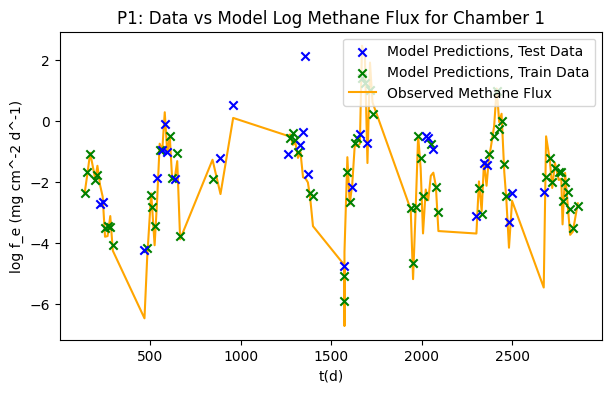

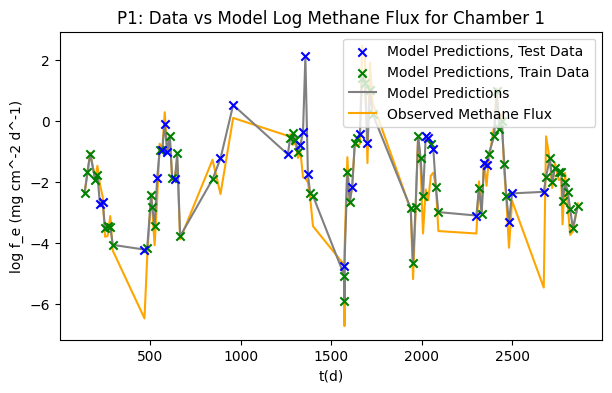

True


In [267]:
wetland = 'P1'
chamber = 1

warnings.filterwarnings('ignore')

compare_model_and_data(wetland, chamber)

In [318]:
# now see if I can plot the x-axis as date
def compare_model_and_data_date_version(wetland, chamber):
    # create a list containing all indices in the original whole data set corresponding
    # to the above wetland and chamber
    index_list = []
    for index, row in df_full.iterrows():
        if row['wetland_ID'] == wetland and row['chamber_ID'] == chamber:
            index_list.append(index)
    
    df_extract = df_full[df_full.index.isin(index_list)]

    x_vals = df_extract['Date Object'].tolist()
    data_flux = df_extract['methane_flux_log_mg_m2_hr'].tolist()
    
    df_extract_test = df_extract[df_extract['TEST_IND'] == 1]
    df_extract_train = df_extract[df_extract['TEST_IND'] == 0]
    
    model_pred_test = df_extract_test['Model Prediction'].tolist()
    model_pred_train = df_extract_train['Model Prediction'].tolist()
    
    x_vals_test = df_extract_test['Date Object'].tolist()
    x_vals_train = df_extract_train['Date Object'].tolist()

    all_model_pred = df_extract['Model Prediction'].tolist()
    
    # okay now plot
    # this plot has scatter points for model predictions and a time series line for observed data
    # no model train scatter plot
    f, ax = plt.subplots()
    f.set_figwidth(7)
    f.set_figheight(4)
    ax.scatter(x_vals_test, model_pred_test, 
                label = "Model Predictions, Test Data",
                marker = "x",
                color = "blue", 
                zorder = 3)
    ax.plot(x_vals, data_flux, 
             label = "Observed Methane Flux", 
             color = "orange", 
             zorder = 0)
    plt.xlabel('Date')
    plt.ylabel('log f_e (mg cm^-2 d^-1)')
    plt.title(str(wetland) + ": Data vs Model Log Methane Flux for Chamber " + str(chamber))
    plt.legend(loc = "upper right")
    plt.show()

    
    # this plot has scatter points for model predictions and a time series line for observed data
    f = plt.figure()
    f.set_figwidth(7)
    f.set_figheight(4)
    plt.scatter(x_vals_test, model_pred_test, 
                label = "Model Predictions, Test Data",
                marker = "x",
                color = "blue", 
                zorder = 3)
    plt.scatter(x_vals_train, model_pred_train,
                label = "Model Predictions, Train Data",
                marker = "x",
                color = "green", 
                zorder = 2)
    plt.plot(x_vals, data_flux, 
             label = "Observed Methane Flux", 
             color = "orange", 
             zorder = 0)
    plt.xlabel('Date')
    plt.ylabel('log f_e (mg cm^-2 d^-1)')
    plt.title(str(wetland) + ": Data vs Model Log Methane Flux for Chamber " + str(chamber))
    plt.legend(loc = "upper right")
    plt.show()

    # okay now plot
    # this plot has scatter points for model predictions and a time series line for observed data
    # and also a time series line for the model predictions
    f = plt.figure()
    f.set_figwidth(7)
    f.set_figheight(4)
    plt.scatter(x_vals_test, model_pred_test, 
                label = "Model Predictions, Test Data",
                marker = "x",
                color = "blue", 
                zorder = 3)
    plt.scatter(x_vals_train, model_pred_train,
                label = "Model Predictions, Train Data",
                marker = "x",
                color = "green", 
                zorder = 2)
    plt.plot(x_vals, all_model_pred,
             label = "Model Predictions", 
             color = "grey", 
             zorder = 1)
    plt.plot(x_vals, data_flux, 
             label = "Observed Methane Flux", 
             color = "orange", 
             zorder = 0)
    plt.xlabel('Date')
    plt.ylabel('log f_e (mg cm^-2 d^-1)')
    plt.title(str(wetland) + ": Data vs Model Log Methane Flux for Chamber " + str(chamber))
    plt.legend(loc = "upper right")
    plt.show()

    print(set(model_pred_test) <= set(predictions_noyr_wfps_water))

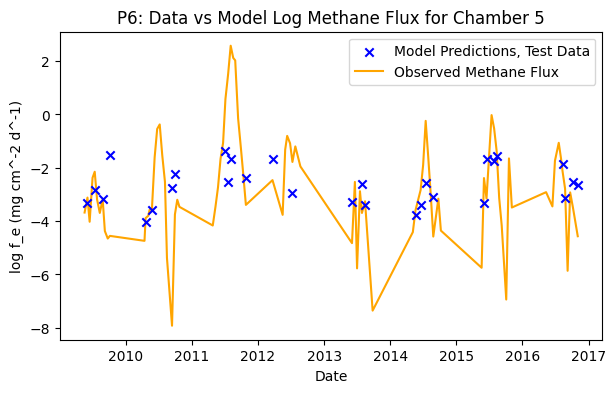

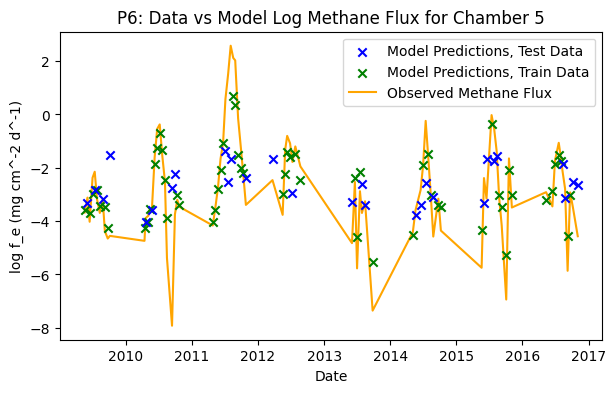

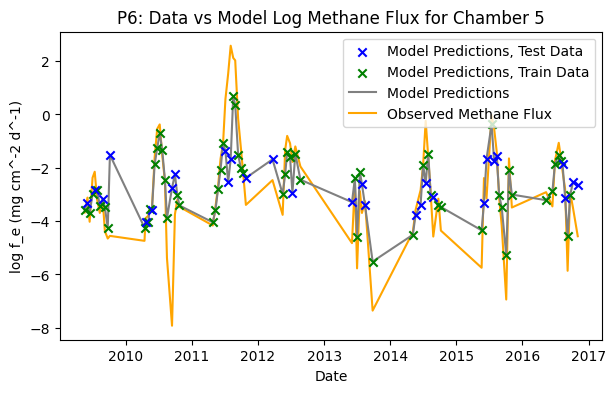

True


In [323]:
wetland = 'P6'
chamber = 5

warnings.filterwarnings('ignore')

compare_model_and_data_date_version(wetland, chamber)

In [360]:
def plot_chambers1_5(wetland):
    index_list = []
    for index, row in df_full.iterrows():
        if row['wetland_ID'] == wetland and (row['chamber_ID'] == 1 or row['chamber_ID'] == 5):
            index_list.append(index)

    df_extract = df_full[df_full.index.isin(index_list)]
    x_vals = df_extract['Date Object'].tolist()

    df_1 = df_extract[df_extract['chamber_ID'] == 1]
    df_5 = df_extract[df_extract['chamber_ID'] == 5]

    data_flux_1 = df_1['methane_flux_log_mg_m2_hr'].tolist()
    data_flux_5 = df_5['methane_flux_log_mg_m2_hr'].tolist()

    pred_flux_1 = df_1['Model Prediction'].tolist()
    pred_flux_5 = df_5['Model Prediction'].tolist()

    x_vals_1 = df_1['Date Object'].tolist()
    x_vals_5 = df_5['Date Object'].tolist()

    hydro_1 = df_1['Hydroperiod_days_fld'].tolist()
    hydro_5 = df_5['Hydroperiod_days_fld'].tolist()

    water_1 = df_1['Water_depth_cm_fld'].tolist()
    water_5 = df_5['Water_depth_cm_fld'].tolist()

    soil_1 = df_1['SoilT_C_fld'].tolist()
    soil_5 = df_5['SoilT_C_fld'].tolist()

    print(len(data_flux_1))
    print(len(data_flux_5))
    
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.scatter(x_vals_1, data_flux_1, label='Chamber 1 (Center), Observed', color='purple', marker = 'x')
    ax.scatter(x_vals_5, data_flux_5, label='Chamber 5 (Edge), Observed', color = 'red', marker='x')
    ax.plot(x_vals_1, pred_flux_1, label='Chamber 1 (Center), Prediction', color='blue')
    ax.plot(x_vals_5, pred_flux_5, label='Chamber 5 (Edge), Prediction', color = 'green', linestyle='--')
    legend = ax.legend(loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('log(CH$_4$)')
    plt.title('Log Methane at Center vs. Edge of Wetland ' + str(wetland))
    plt.show()

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(x_vals_1, hydro_1, label='Chamber 1 (Center)', color='blue')
    ax.plot(x_vals_5, hydro_5, label='Chamber 5 (Edge)', color = 'green', linestyle='--')
    legend = ax.legend(loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('Hydroperiod')
    plt.title('Hydroperiod at Center vs. Edge of Wetland ' + str(wetland))
    plt.show()

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(x_vals_1, water_1, label='Chamber 1 (Center)', color='blue')
    ax.plot(x_vals_5, water_5, label='Chamber 5 (Edge)', color = 'green', linestyle='--')
    legend = ax.legend(loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('Water Depth')
    plt.title('Water Depth at Center vs. Edge of Wetland ' + str(wetland))
    plt.show()

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(x_vals_1, soil_1, label='Chamber 1 (Center)', color='blue')
    ax.plot(x_vals_5, soil_5, label='Chamber 5 (Edge)', color = 'green', linestyle='--')
    legend = ax.legend(loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('Soil Temp')
    plt.title('Soil Temp at Center vs. Edge of Wetland ' + str(wetland))
    plt.show()

97
87


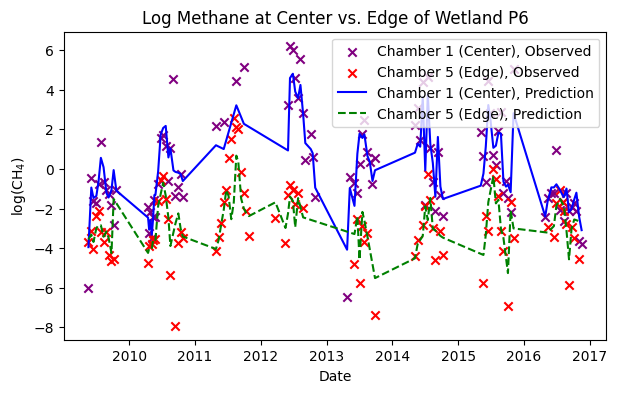

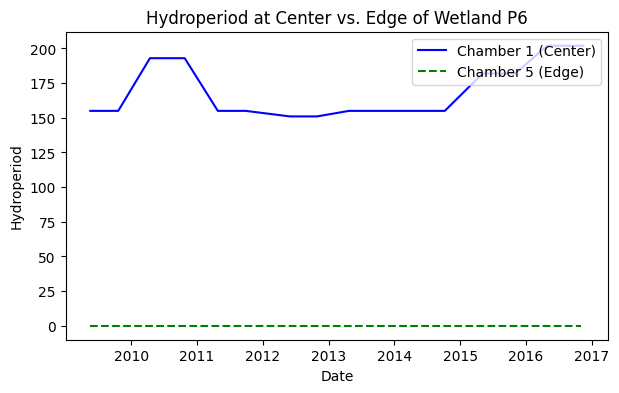

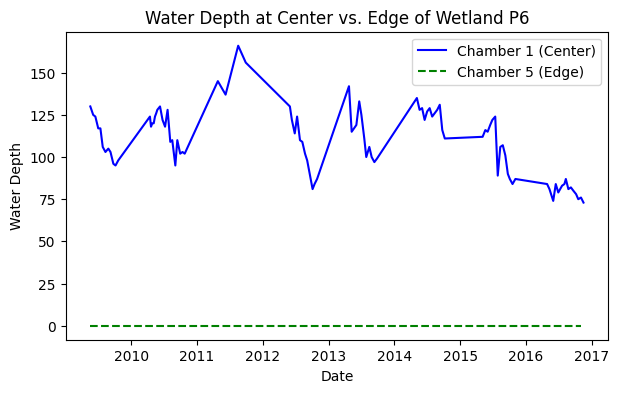

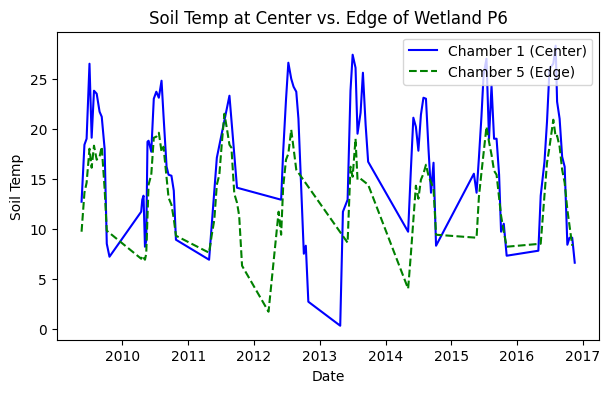

In [361]:
plot_chambers1_5('P6')

In [345]:
df_full['wetland_ID'].unique()

array(['BECK 5', 'BECK 6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'DU01', 'DU02', 'DU03', 'DU05', 'DU06', 'DU07', 'DU08', 'DU09',
       'DU10', 'DU11', 'DU12', 'DU13', 'DU14', 'DU15', 'DU17', 'F1', 'F2',
       'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'GP01157', 'GP01158',
       'GP01314', 'GP01317', 'GP01318', 'GP01323', 'GP01325', 'GP01326',
       'GP01604', 'GP01605', 'GP01606', 'GP01607', 'GP01608', 'GP01609',
       'GP01610', 'GP01611', 'GP01612', 'GP01613', 'GP01615', 'GP01617',
       'GP01618', 'GP01619', 'GP01624', 'GP01626', 'GP01627', 'GP01630',
       'GP01631', 'GP01633', 'GP01634', 'GP01635', 'GP01637', 'GP01638',
       'GP01639', 'GP09644', 'GP09645', 'GP09646', 'GP09647', 'GP09648',
       'GP09649', 'GP09650', 'GP09651', 'GP09652', 'GP09653', 'GP09654',
       'GP09655', 'GP09656', 'GP09657', 'GP09658', 'GP09659', 'GP09664',
       'GP09665', 'GP09666', 'GP09667', 'GP09668', 'GP09669', 'GP09670',
       'GP09671', 'GP09672', 'GP09673', 'GP09674', 'GP096

In [346]:
df_full.columns

Index(['chamber_ID', 'Date', 'GS_Interval_fld', 'Hydroperiod_days_fld',
       'LAB_ID', 'Land_Cover_fld', 'methane_flux_log_mg_m2_hr', 'NDVI_lag_rs',
       'NDVI_rs', 'Size_m2_fld', 'SoilT_C_fld', 'SoilT_lag_C_fld',
       'Water_depth_cm_fld', 'Wetland_Chamber', 'wetland_ID',
       'WFPS_lag_pcnt_fld', 'WFPS_pcnt_fld', 'Date Object', 'Month', 'Year',
       'TEST_IND', 'Model Prediction', 'Days Since Jan 1, 2009'],
      dtype='object')

In [ ]:
# also plot hydroperiod of the chambers (1 and 5) over time
# plot the water depth of the chambers (1 and 5) over time
# try combos of soil temp, water depth, and WFPS and see the peaks (plot over time and see what could be explaining the odd peaks) and see if the predictions are closer to the observed fluxes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18803 entries, 0 to 18802
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hydroperiod_days_fld  18803 non-null  float64
 1   NDVI_lag_rs           18803 non-null  float64
 2   Size_m2_fld           18803 non-null  float64
 3   SoilT_lag_C_fld       18803 non-null  float64
 4   Month                 18803 non-null  int32  
dtypes: float64(4), int32(1)
memory usage: 661.2 KB
None
R-squared, no max depth, using soil temperature: 0.6009068037458267


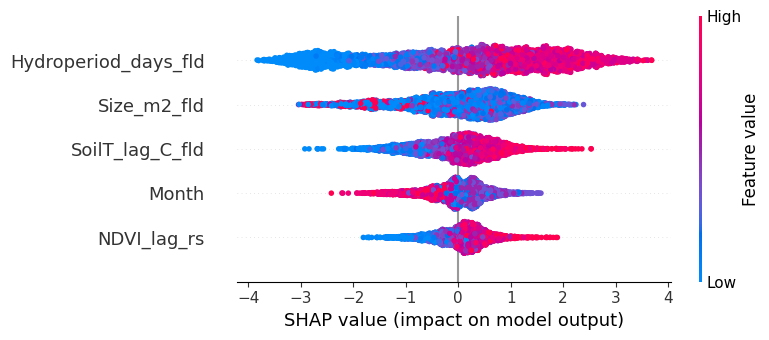

In [398]:
# train a model with soil temp
X_soil = df_full[['Hydroperiod_days_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_lag_C_fld', 'Month']]
y_soil = df_full['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

# x_noyr_wfps_water_categorical = X_noyr_wfps_water.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_soil_numerical = X_soil.select_dtypes(exclude = ['object'])

# x_noyr_wfps_water = pd.concat([x_noyr_wfps_water_categorical, x_noyr_wfps_water_numerical], axis = 1)
x_soil = x_soil_numerical

# print(x_pos)
print(x_soil.info())

X_soil_train, X_soil_test, y_soil_train, y_soil_test = train_test_split(x_soil, 
                                                                                                                    y_soil,
                                                                                                                    test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_soil = RandomForestRegressor(oob_score = True)

regressor_soil.fit(X_soil_train, y_soil_train)

predictions_soil = regressor_soil.predict(X_soil_test)
print(f'R-squared, no max depth, using soil temperature: {r2_score(y_soil_test, predictions_soil)}')

# SHAP plot
explainer_soil = shap.Explainer(regressor_soil)

shap_values_soil = explainer_soil.shap_values(X_soil_test)
shap.summary_plot(shap_values_soil, X_soil_test)

In [ ]:
# train a model with WFPS instead of soil temp
X_wfps = df_full[['Hydroperiod_days_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'WFPS_lag_pcnt_fld', 'Month']]
y_wfps = df_full['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

# x_noyr_wfps_water_categorical = X_noyr_wfps_water.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_wfps_numerical = X_wfps.select_dtypes(exclude = ['object'])

# x_noyr_wfps_water = pd.concat([x_noyr_wfps_water_categorical, x_noyr_wfps_water_numerical], axis = 1)
x_wfps = x_wfps_numerical

# print(x_pos)
print(x_wfps.info())

X_wfps_train, X_wfps_test, y_wfps_train, y_wfps_test = train_test_split(x_wfps, 
                                                                                                                    y_wfps,
                                                                                                                    test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_wfps = RandomForestRegressor(oob_score = True)

regressor_wfps.fit(X_wfps_train, y_wfps_train)

predictions_wfps = regressor_wfps.predict(X_wfps_test)
print(f'R-squared, no max depth, using WFPS: {r2_score(y_wfps_test, predictions_wfps)}')

# SHAP plot
explainer_wfps = shap.Explainer(regressor_wfps)

shap_values_wfps = explainer_wfps.shap_values(X_wfps_test)
shap.summary_plot(shap_values_wfps, X_wfps_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18803 entries, 0 to 18802
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hydroperiod_days_fld  18803 non-null  float64
 1   NDVI_lag_rs           18803 non-null  float64
 2   Size_m2_fld           18803 non-null  float64
 3   Water_depth_cm_fld    18803 non-null  float64
 4   Month                 18803 non-null  int32  
dtypes: float64(4), int32(1)
memory usage: 661.2 KB
None
R-squared, no max depth, using water depth: 0.6296343419895795


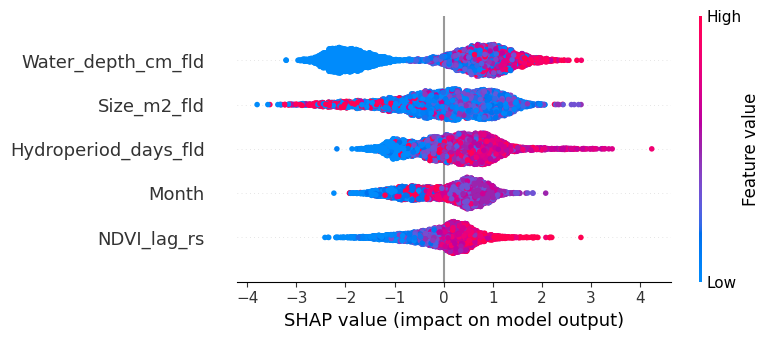

In [364]:
# train a model with water depth instead of soil temp
X_water = df_full[['Hydroperiod_days_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'Water_depth_cm_fld', 'Month']]
y_water = df_full['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

# x_noyr_wfps_water_categorical = X_noyr_wfps_water.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_water_numerical = X_water.select_dtypes(exclude = ['object'])

# x_noyr_wfps_water = pd.concat([x_noyr_wfps_water_categorical, x_noyr_wfps_water_numerical], axis = 1)
x_water = x_water_numerical

# print(x_pos)
print(x_water.info())

X_water_train, X_water_test, y_water_train, y_water_test = train_test_split(x_water, 
                                                                                                                    y_water,
                                                                                                                    test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_water = RandomForestRegressor(oob_score = True)

regressor_water.fit(X_water_train, y_water_train)

predictions_water = regressor_water.predict(X_water_test)
print(f'R-squared, no max depth, using water depth: {r2_score(y_water_test, predictions_water)}')

# SHAP plot
explainer_water = shap.Explainer(regressor_water)

shap_values_water = explainer_water.shap_values(X_water_test)
shap.summary_plot(shap_values_water, X_water_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18803 entries, 0 to 18802
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hydroperiod_days_fld  18803 non-null  float64
 1   NDVI_lag_rs           18803 non-null  float64
 2   Size_m2_fld           18803 non-null  float64
 3   SoilT_lag_C_fld       18803 non-null  float64
 4   WFPS_lag_pcnt_fld     18803 non-null  float64
 5   Month                 18803 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 808.1 KB
None
R-squared, no max depth, using wfps and soil temp: 0.6120704671770592


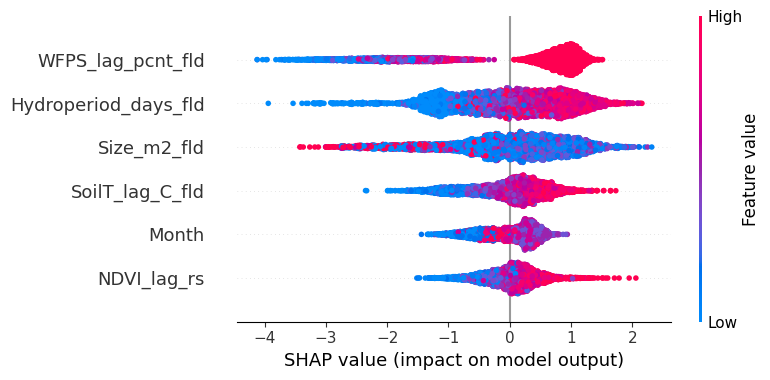

In [367]:
# train a model with wfps and soil temp
X_soil_wfps = df_full[['Hydroperiod_days_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_lag_C_fld', 'WFPS_lag_pcnt_fld', 'Month']]
y_soil_wfps = df_full['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

# x_noyr_wfps_water_categorical = X_noyr_wfps_water.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_soil_wfps_numerical = X_soil_wfps.select_dtypes(exclude = ['object'])

# x_noyr_wfps_water = pd.concat([x_noyr_wfps_water_categorical, x_noyr_wfps_water_numerical], axis = 1)
x_soil_wfps = x_soil_wfps_numerical

# print(x_pos)
print(x_soil_wfps.info())

X_soil_wfps_train, X_soil_wfps_test, y_soil_wfps_train, y_soil_wfps_test = train_test_split(x_soil_wfps, 
                                                                                                                    y_soil_wfps,
                                                                                                                    test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_soil_wfps = RandomForestRegressor(oob_score = True)

regressor_soil_wfps.fit(X_soil_wfps_train, y_soil_wfps_train)

predictions_soil_wfps = regressor_soil_wfps.predict(X_soil_wfps_test)
print(f'R-squared, no max depth, using wfps and soil temp: {r2_score(y_soil_wfps_test, predictions_soil_wfps)}')

# SHAP plot
explainer_soil_wfps = shap.Explainer(regressor_soil_wfps)

shap_values_soil_wfps = explainer_soil_wfps.shap_values(X_soil_wfps_test)
shap.summary_plot(shap_values_soil_wfps, X_soil_wfps_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18803 entries, 0 to 18802
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hydroperiod_days_fld  18803 non-null  float64
 1   NDVI_lag_rs           18803 non-null  float64
 2   Size_m2_fld           18803 non-null  float64
 3   SoilT_lag_C_fld       18803 non-null  float64
 4   Water_depth_cm_fld    18803 non-null  float64
 5   Month                 18803 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 808.1 KB
None
R-squared, no max depth, using water depth and soil temp: 0.6181047060713218


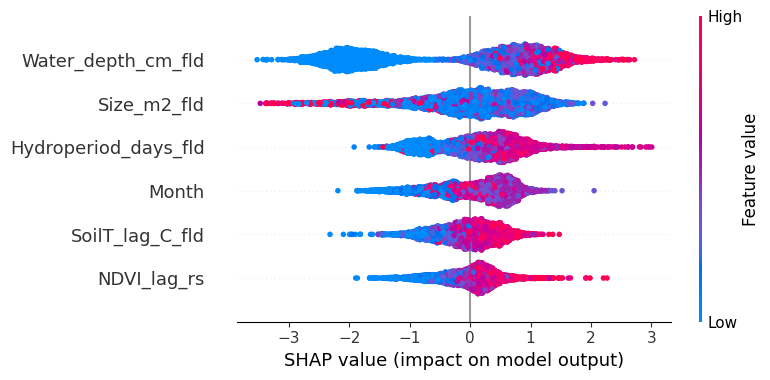

In [369]:
# train a model with water depth and soil temp
X_soil_water = df_full[['Hydroperiod_days_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_lag_C_fld', 'Water_depth_cm_fld', 'Month']]
y_soil_water = df_full['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

# x_noyr_wfps_water_categorical = X_noyr_wfps_water.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_soil_water_numerical = X_soil_water.select_dtypes(exclude = ['object'])

# x_noyr_wfps_water = pd.concat([x_noyr_wfps_water_categorical, x_noyr_wfps_water_numerical], axis = 1)
x_soil_water = x_soil_water_numerical

# print(x_pos)
print(x_soil_water.info())

X_soil_water_train, X_soil_water_test, y_soil_water_train, y_soil_water_test = train_test_split(x_soil_water, 
                                                                                                                    y_soil_water,
                                                                                                                    test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_soil_water = RandomForestRegressor(oob_score = True)

regressor_soil_water.fit(X_soil_water_train, y_soil_water_train)

predictions_soil_water = regressor_soil_water.predict(X_soil_water_test)
print(f'R-squared, no max depth, using water depth and soil temp: {r2_score(y_soil_water_test, predictions_soil_water)}')

# SHAP plot
explainer_soil_water = shap.Explainer(regressor_soil_water)

shap_values_soil_water = explainer_soil_water.shap_values(X_soil_water_test)
shap.summary_plot(shap_values_soil_water, X_soil_water_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18803 entries, 0 to 18802
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hydroperiod_days_fld  18803 non-null  float64
 1   NDVI_lag_rs           18803 non-null  float64
 2   Size_m2_fld           18803 non-null  float64
 3   Water_depth_cm_fld    18803 non-null  float64
 4   WFPS_lag_pcnt_fld     18803 non-null  float64
 5   Month                 18803 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 808.1 KB
None
R-squared, no max depth, using water depth and wfps: 0.6396817318068593


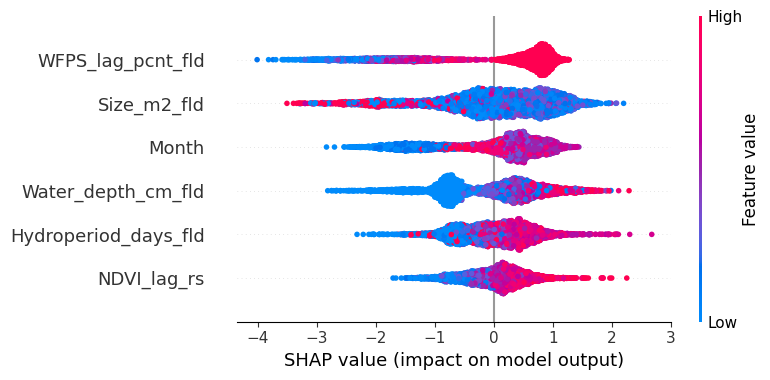

In [370]:
# train a model with water depth and wfps
X_water_wfps = df_full[['Hydroperiod_days_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'Water_depth_cm_fld', 'WFPS_lag_pcnt_fld', 'Month']]
y_water_wfps = df_full['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

# x_noyr_wfps_water_categorical = X_noyr_wfps_water.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_water_wfps_numerical = X_water_wfps.select_dtypes(exclude = ['object'])

# x_noyr_wfps_water = pd.concat([x_noyr_wfps_water_categorical, x_noyr_wfps_water_numerical], axis = 1)
x_water_wfps = x_water_wfps_numerical

# print(x_pos)
print(x_water_wfps.info())

X_water_wfps_train, X_water_wfps_test, y_water_wfps_train, y_water_wfps_test = train_test_split(x_water_wfps, 
                                                                                                                    y_water_wfps,
                                                                                                                    test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_water_wfps = RandomForestRegressor(oob_score = True)

regressor_water_wfps.fit(X_water_wfps_train, y_water_wfps_train)

predictions_water_wfps = regressor_water_wfps.predict(X_water_wfps_test)
print(f'R-squared, no max depth, using water depth and wfps: {r2_score(y_water_wfps_test, predictions_water_wfps)}')

# SHAP plot
explainer_water_wfps = shap.Explainer(regressor_water_wfps)

shap_values_water_wfps = explainer_water_wfps.shap_values(X_water_wfps_test)
shap.summary_plot(shap_values_water_wfps, X_water_wfps_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18803 entries, 0 to 18802
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hydroperiod_days_fld  18803 non-null  float64
 1   NDVI_lag_rs           18803 non-null  float64
 2   Size_m2_fld           18803 non-null  float64
 3   SoilT_lag_C_fld       18803 non-null  float64
 4   Water_depth_cm_fld    18803 non-null  float64
 5   WFPS_lag_pcnt_fld     18803 non-null  float64
 6   Month                 18803 non-null  int32  
dtypes: float64(6), int32(1)
memory usage: 955.0 KB
None
R-squared, no max depth, using soil temp, water depth, and wfps: 0.6535240079745495


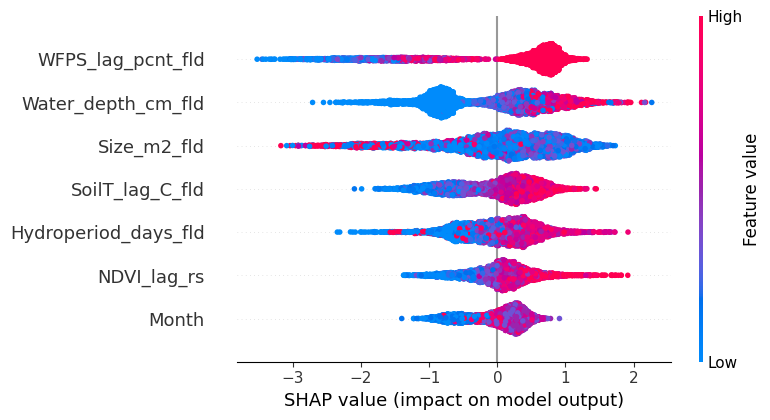

In [371]:
# train a model with soil tempt, water depth, and wfps
X_soil_water_wfps = df_full[['Hydroperiod_days_fld', 'NDVI_lag_rs', 'Size_m2_fld', 'SoilT_lag_C_fld', 'Water_depth_cm_fld', 'WFPS_lag_pcnt_fld', 'Month']]
y_soil_water_wfps = df_full['methane_flux_log_mg_m2_hr']

# Converting categorical variables into numerical

# x_noyr_wfps_water_categorical = X_noyr_wfps_water.select_dtypes(include = ['object']).apply(label_encoder.fit_transform)
x_soil_water_wfps_numerical = X_soil_water_wfps.select_dtypes(exclude = ['object'])

# x_noyr_wfps_water = pd.concat([x_noyr_wfps_water_categorical, x_noyr_wfps_water_numerical], axis = 1)
x_soil_water_wfps = x_soil_water_wfps_numerical

# print(x_pos)
print(x_soil_water_wfps.info())

X_soil_water_wfps_train, X_soil_water_wfps_test, y_soil_water_wfps_train, y_soil_water_wfps_test = train_test_split(x_soil_water_wfps, 
                                                                                                                    y_soil_water_wfps,
                                                                                                                    test_size = 0.3)

# Fitting and Evaluating the Random Forest Model

regressor_soil_water_wfps = RandomForestRegressor(oob_score = True)

regressor_soil_water_wfps.fit(X_soil_water_wfps_train, y_soil_water_wfps_train)

predictions_soil_water_wfps = regressor_soil_water_wfps.predict(X_soil_water_wfps_test)
print(f'R-squared, no max depth, using soil temp, water depth, and wfps: {r2_score(y_soil_water_wfps_test, predictions_soil_water_wfps)}')

# SHAP plot
explainer_soil_water_wfps = shap.Explainer(regressor_soil_water_wfps)

shap_values_soil_water_wfps = explainer_soil_water_wfps.shap_values(X_soil_water_wfps_test)
shap.summary_plot(shap_values_soil_water_wfps, X_soil_water_wfps_test)

In [373]:
df_full['TEST_IND'].sum()

np.int64(5641)

In [392]:
 # predict on training set
predictions_on_train_noyr_wfps_water = regressor_noyr_wfps_water.predict(X_noyr_wfps_water_train)

# actually maybe I just add 2 columns to the df, one for train vs test indicator and one for model prediction
# regressor_noyr_wfps_water
train_index = X_noyr_wfps_water_train.index
test_index = X_noyr_wfps_water_test.index


def test_ind(index, ind_lst):
    if index in ind_lst:
        return 0
    else:
        return 1

def grab_model_pred(index):
    if index in train_index:
        ind_in_train = train_index.tolist().index(index)
        model_pred = predictions_on_train_noyr_wfps_water[ind_in_train]
        return model_pred
    else:
        ind_in_test = test_index.tolist().index(index)
        model_pred = predictions_noyr_wfps_water[ind_in_test]
        return model_pred


#df_full['TEST_IND'] = df_full.index.apply(lambda x: test_ind(x, train_index))
df_full['Model Prediction'] = df_full.index.map(grab_model_pred)

df_full["TEST_IND"] = np.where(
    (df_full.index.isin(test_index)),
    1, 0)

In [390]:
def grab_model_pred(index, train_index, test_index, model_pred, model_pred_train):
    if index in train_index:
        ind_in_train = train_index.tolist().index(index)
        model_pred = model_pred_train[ind_in_train]
        return model_pred
    else:
        ind_in_test = test_index.tolist().index(index)
        model_pred = model_pred[ind_in_test]
        return model_pred

df_full['Model Prediction'] = df_full.index.map(lambda x: grab_model_pred(x, train_index, test_index, predictions_noyr_wfps_water, 
                                                                         predictions_on_train_noyr_wfps_water))

In [396]:
def test_ind(index, ind_lst):
    if index in ind_lst:
        return 0
    else:
        return 1

def grab_model_pred(index, train_index, test_index, model_pred, model_pred_train):
    if index in train_index:
        ind_in_train = train_index.tolist().index(index)
        model_pred = model_pred_train[ind_in_train]
        return model_pred
    else:
        ind_in_test = test_index.tolist().index(index)
        model_pred = model_pred[ind_in_test]
        return model_pred

def prepare(df, X_train, X_test, model_name_end, model_pred, model):
    model_pred_train = model.predict(X_train)

    # add 2 columns to the df, one for train vs test indicator and one for model predictions
    test_ind_name = 'TEST_IND' + '_' + model_name_end
    train_index = X_train.index
    test_index = X_test.index

    df_full[test_ind_name] = np.where(
        (df_full.index.isin(test_index)),
        1, 0)

    model_pred_name = 'Model Prediction ' + model_name_end
    df_full[model_pred_name] = df_full.index.map(lambda x: grab_model_pred(x, train_index, test_index, model_pred, 
                                                                         model_pred_train))

In [395]:
dfcopy = df_full

In [401]:
prepare(dfcopy, X_soil_train, X_soil_test, 'SOIL', predictions_soil, regressor_soil)
prepare(dfcopy, X_water_train, X_water_test, 'WATER', predictions_water, regressor_water)
prepare(dfcopy, X_wfps_train, X_wfps_test, 'WFPS', predictions_wfps, regressor_wfps)
prepare(dfcopy, X_soil_wfps_train, X_soil_wfps_test, 'SOIL_WFPS', predictions_soil_wfps, regressor_soil_wfps)
prepare(dfcopy, X_soil_water_train, X_soil_water_test, 'SOIL_WATER', predictions_soil_water, regressor_soil_water)
prepare(dfcopy, X_water_wfps_train, X_water_wfps_test, 'WATER_WFPS', predictions_water_wfps, regressor_water_wfps)
prepare(dfcopy, X_soil_water_wfps_train, X_soil_water_wfps_test, 'SOIL_WATER_WFPS', predictions_soil_water_wfps, regressor_soil_water_wfps)

In [403]:
dfcopy.columns.tolist()

['chamber_ID',
 'Date',
 'GS_Interval_fld',
 'Hydroperiod_days_fld',
 'LAB_ID',
 'Land_Cover_fld',
 'methane_flux_log_mg_m2_hr',
 'NDVI_lag_rs',
 'NDVI_rs',
 'Size_m2_fld',
 'SoilT_C_fld',
 'SoilT_lag_C_fld',
 'Water_depth_cm_fld',
 'Wetland_Chamber',
 'wetland_ID',
 'WFPS_lag_pcnt_fld',
 'WFPS_pcnt_fld',
 'Date Object',
 'Month',
 'Year',
 'TEST_IND',
 'Model Prediction',
 'Days Since Jan 1, 2009',
 'TEST_IND_SOIL',
 'Model Prediction SOIL',
 'TEST_IND_WATER',
 'Model Prediction WATER',
 'TEST_IND_WFPS',
 'Model Prediction WFPS',
 'TEST_IND_SOIL_WFPS',
 'Model Prediction SOIL_WFPS',
 'TEST_IND_SOIL_WATER',
 'Model Prediction SOIL_WATER',
 'TEST_IND_WATER_WFPS',
 'Model Prediction WATER_WFPS',
 'TEST_IND_SOIL_WATER_WFPS',
 'Model Prediction SOIL_WATER_WFPS']

In [597]:
def plots_general(wetland, model_name):
    index_list = []
    for index, row in df_full.iterrows():
        if row['wetland_ID'] == wetland and (row['chamber_ID'] == 1 or row['chamber_ID'] == 5):
            index_list.append(index)

    df_extract = dfcopy[dfcopy.index.isin(index_list)]
    x_vals = df_extract['Date Object'].tolist()

    df_1 = df_extract[df_extract['chamber_ID'] == 1]
    df_5 = df_extract[df_extract['chamber_ID'] == 5]

    data_flux_1 = df_1['methane_flux_log_mg_m2_hr'].tolist()
    data_flux_5 = df_5['methane_flux_log_mg_m2_hr'].tolist()

    model_pred_name = 'Model Prediction ' + model_name
    pred_flux_1 = df_1[model_pred_name].tolist()
    pred_flux_5 = df_5[model_pred_name].tolist()

    x_vals_1 = df_1['Date Object'].tolist()
    x_vals_5 = df_5['Date Object'].tolist()

    hydro_1 = df_1['Hydroperiod_days_fld'].tolist()
    hydro_5 = df_5['Hydroperiod_days_fld'].tolist()

    water_1 = df_1['Water_depth_cm_fld'].tolist()
    water_5 = df_5['Water_depth_cm_fld'].tolist()

    soil_1 = df_1['SoilT_C_fld'].tolist()
    soil_5 = df_5['SoilT_C_fld'].tolist()

    wfps_1 = df_1['WFPS_pcnt_fld'].tolist()
    wfps_5 = df_5['WFPS_pcnt_fld'].tolist()

    # print(len(data_flux_1))
    # print(len(data_flux_5))
    
    fig, ax = plt.subplots(3, 2, figsize=(14, 15))
    ax[0,0].scatter(x_vals_1, data_flux_1, label='Ch 1 (Center), Obs', color='blue', marker = 'x')
    ax[0,0].scatter(x_vals_5, data_flux_5, label='Ch 5 (Edge), Obs', color = 'red', marker='x')
    ax[0,0].plot(x_vals_1, pred_flux_1, label='Ch 1 (Center), Pred', color='blue')
    ax[0,0].plot(x_vals_5, pred_flux_5, label='Ch 5 (Edge), Pred', color = 'red', linestyle='--')
    legend = ax[0,0].legend(loc='upper right')
    # plt.xlabel('Date')
    ax[0,0].set_ylabel('log(CH$_4$)')
    # plt.title(model_name + 'Log Methane at Center vs. Edge of Wetland ' + str(wetland))
    ax[0,0].set_xlabel('Date')
    ax[0,0].set_title(model_name + ' Model: Log Methane at Center vs. Edge of Wetland ' + str(wetland))
    # plt.show()

    ax[0,1].plot(x_vals_5, data_flux_5, label='Observed Methane', color = 'blue')
    ax[0,1].scatter(x_vals_5, pred_flux_5, label='Predicted Methane', color = 'green', marker = 'x')
    ax2 = ax[0,1].twinx()
    ax2.plot(x_vals_5, wfps_5, label='WFPS', color='orange')
    legend = ax[0,1].legend(loc='upper right')
    legend2 = ax2.legend(loc = 'upper left')
    ax[0,1].set_xlabel('Date')
    ax[0,1].set_ylabel('log(CH$_4$)')
    ax2.set_ylabel('WFPS')
    ax[0,1].set_title('Methane Flux for Edge (Chamber 5) and WFPS for Wetland ' + str(wetland))

    # fig, ax = plt.subplots(figsize=(7, 4))
    ax[2,1].plot(x_vals_1, hydro_1, label='Chamber 1 (Center)', color='blue')
    ax[2,1].plot(x_vals_5, hydro_5, label='Chamber 5 (Edge)', color = 'green', linestyle='--')
    legend = ax[2,1].legend(loc='upper right')
    ax[2,1].set_xlabel('Date')
    ax[2,1].set_ylabel('Hydroperiod')
    ax[2,1].set_title('Hydroperiod at Center vs. Edge of Wetland ' + str(wetland))
    # plt.show()

    # fig, ax = plt.subplots(figsize=(7, 4))
    ax[1,0].plot(x_vals_1, water_1, label='Chamber 1 (Center)', color='blue')
    ax[1,0].plot(x_vals_5, water_5, label='Chamber 5 (Edge)', color = 'green', linestyle='--')
    legend = ax[1,0].legend(loc='upper right')
    ax[1,0].set_xlabel('Date')
    ax[1,0].set_ylabel('Water Depth')
    ax[1,0].set_title('Water Depth at Center vs. Edge of Wetland ' + str(wetland))
    # plt.show()

    # fig, ax = plt.subplots(figsize=(7, 4))
    ax[1,1].plot(x_vals_1, soil_1, label='Chamber 1 (Center)', color='blue')
    ax[1,1].plot(x_vals_5, soil_5, label='Chamber 5 (Edge)', color = 'green', linestyle='--')
    legend = ax[1,1].legend(loc='upper right')
    ax[1,1].set_xlabel('Date')
    ax[1,1].set_ylabel('Soil Temp')
    ax[1,1].set_title('Soil Temp at Center vs. Edge of Wetland ' + str(wetland))

    ax[2,0].plot(x_vals_1, wfps_1, label='Chamber 1 (Center)', color='blue')
    ax[2,0].plot(x_vals_5, wfps_5, label='Chamber 5 (Edge)', color = 'green', linestyle='--')
    legend = ax[2,0].legend(loc='upper right')
    ax[2,0].set_xlabel('Date')
    ax[2,0].set_ylabel('WFPS')
    ax[2,0].set_title('WFPS at Center vs. Edge of Wetland ' + str(wetland))
    
    plt.show()

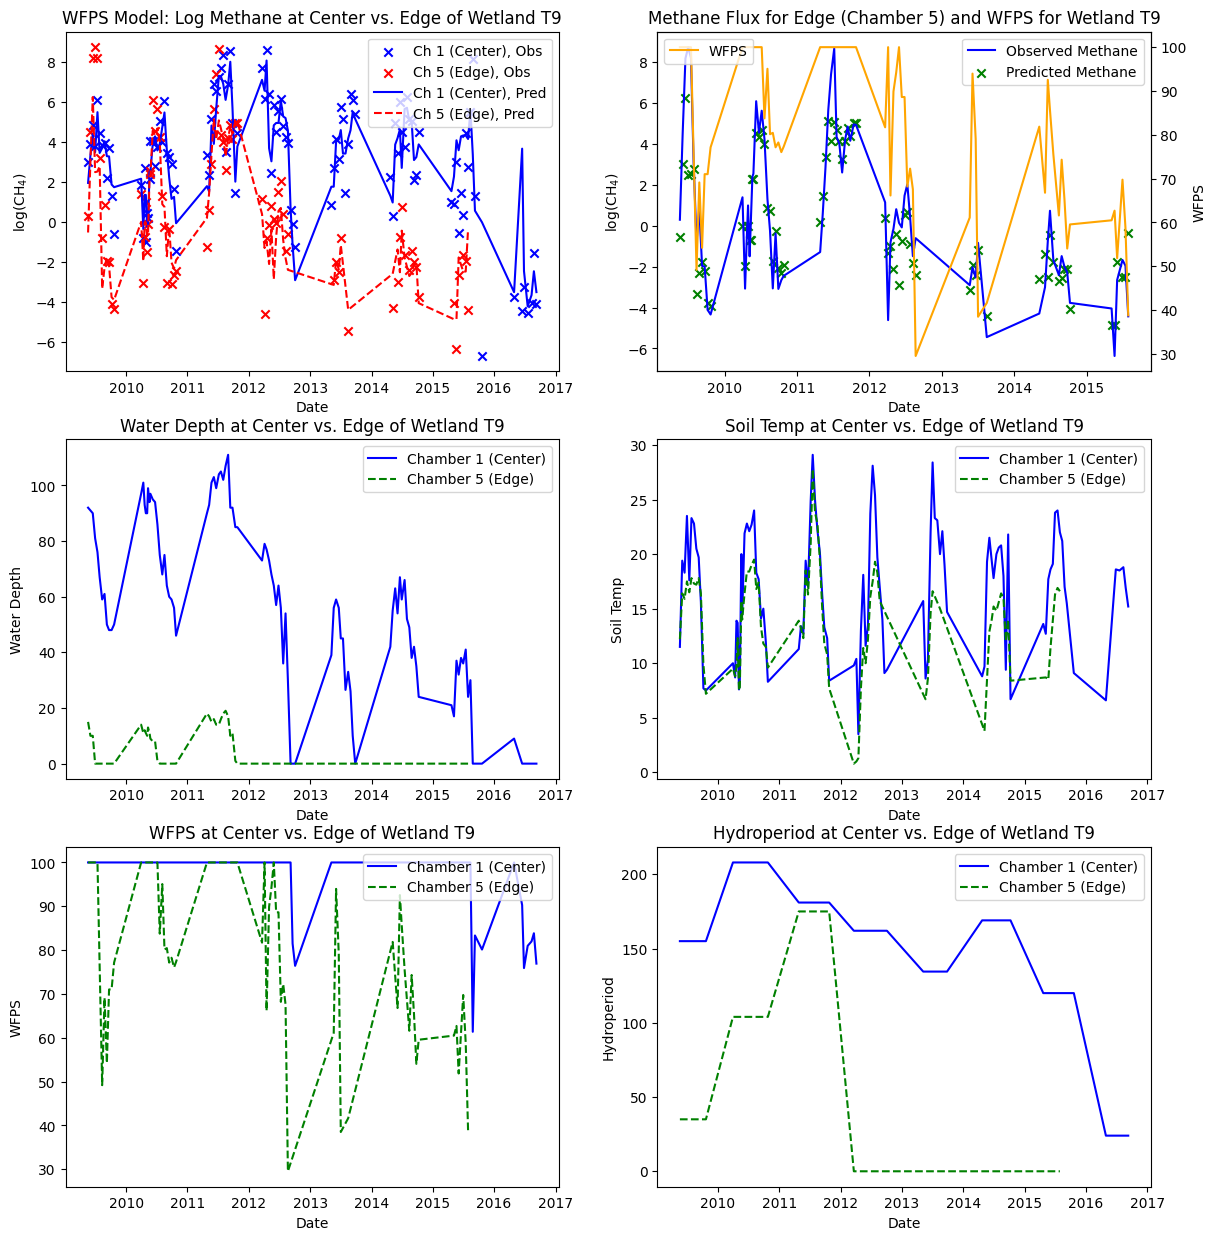

In [608]:
plots_general('T9', 'WFPS')

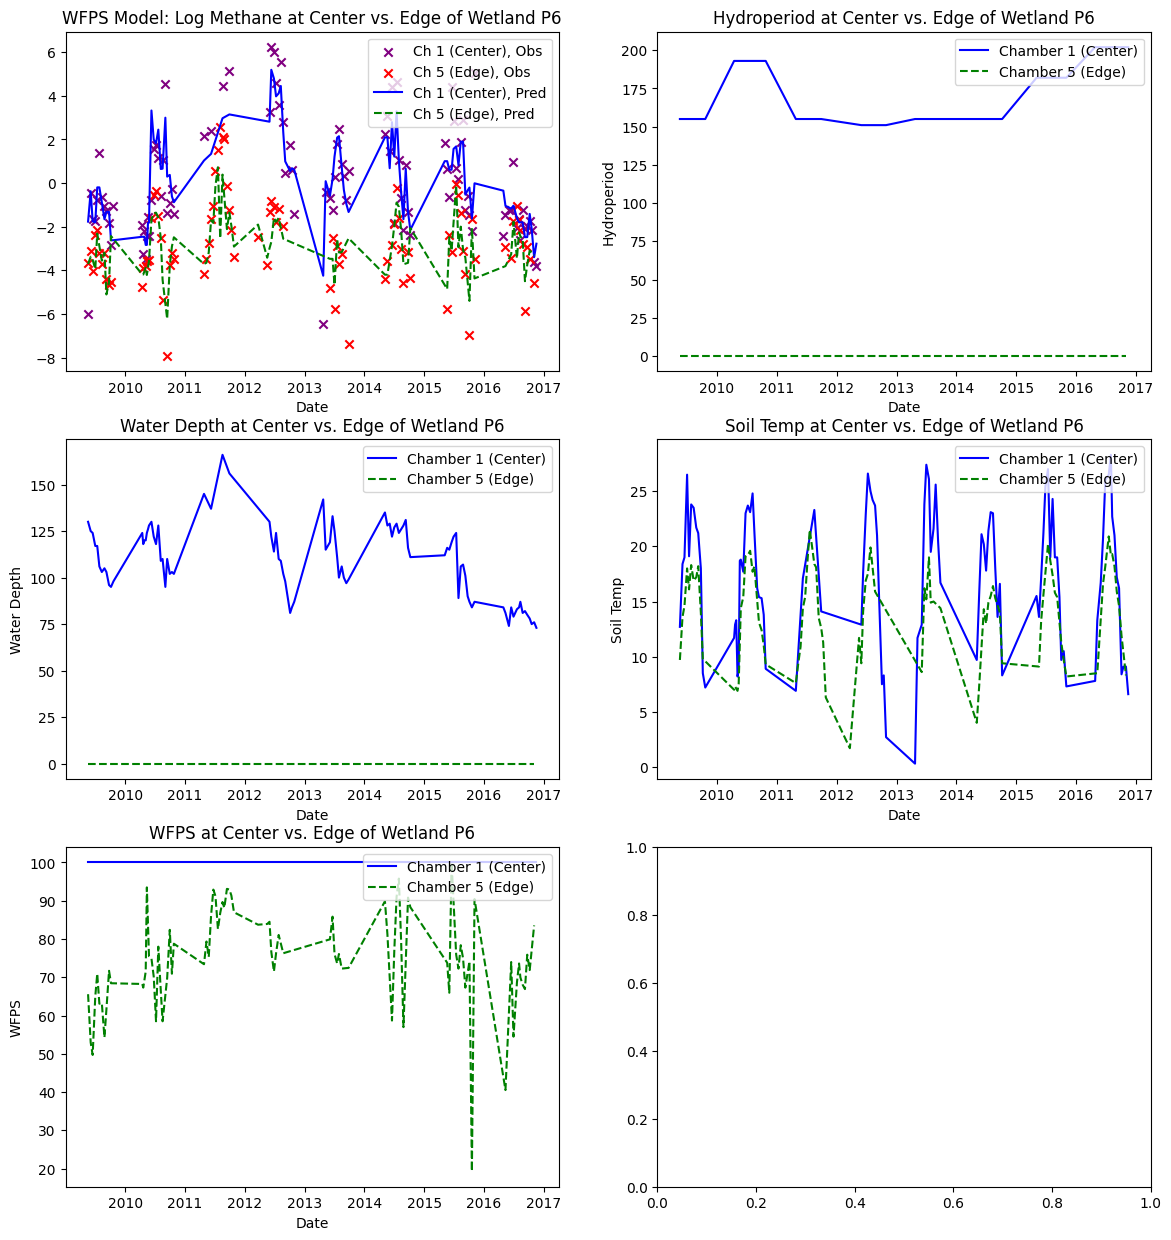

In [441]:
plots_general('P6', 'WFPS')

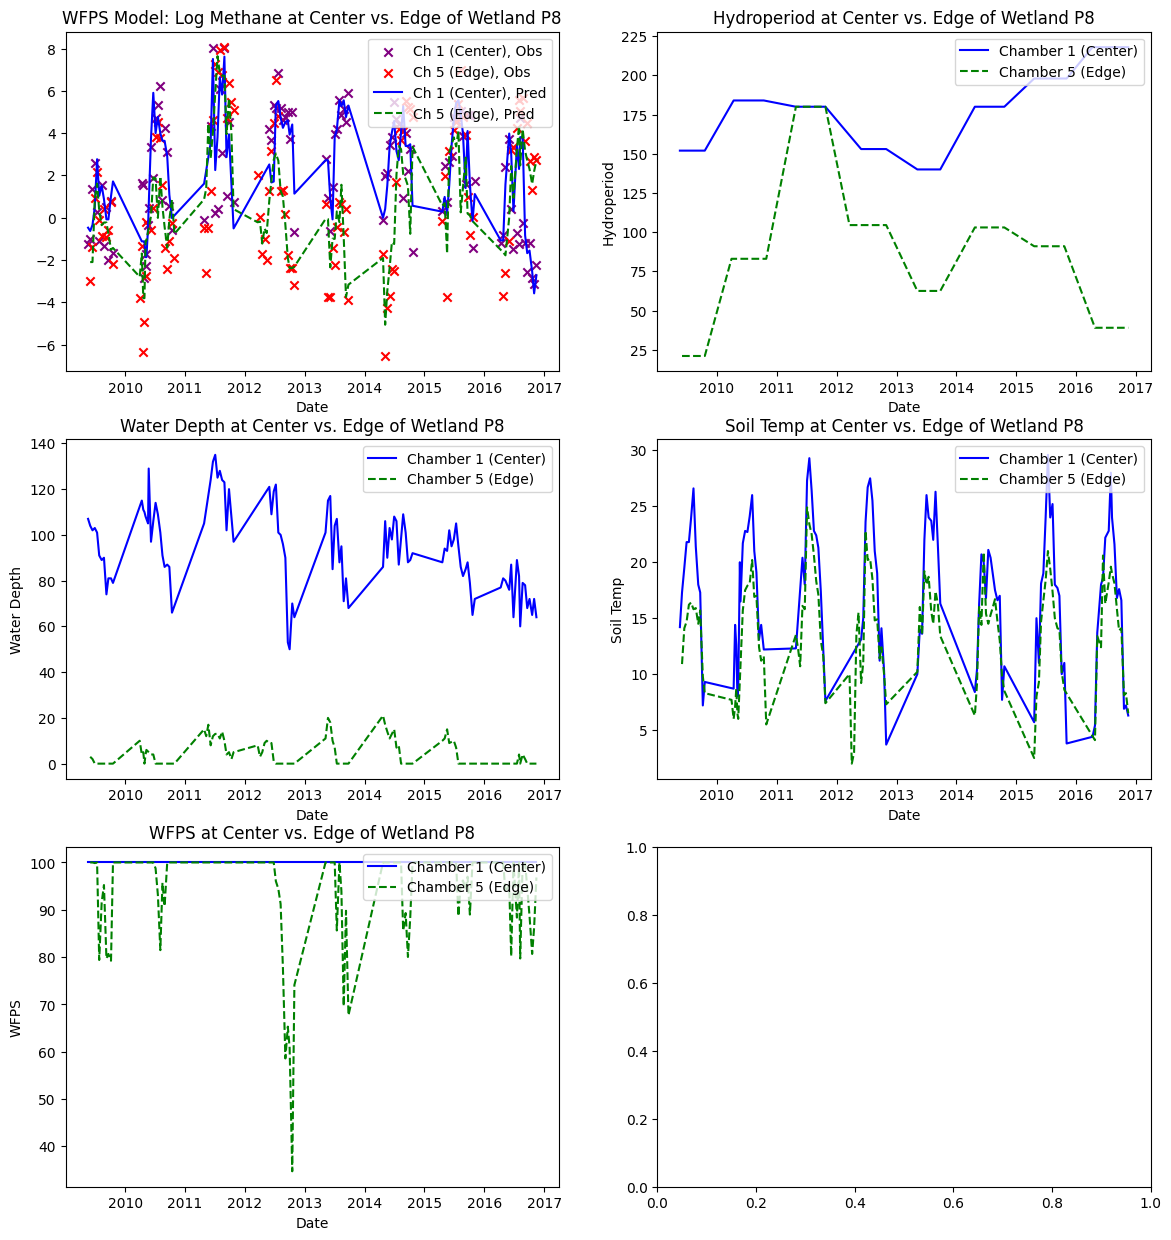

In [443]:
plots_general('P8', 'WFPS')

In [557]:
dfcopy['wetland_ID'].unique()

array(['BECK 5', 'BECK 6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8',
       'DU01', 'DU02', 'DU03', 'DU05', 'DU06', 'DU07', 'DU08', 'DU09',
       'DU10', 'DU11', 'DU12', 'DU13', 'DU14', 'DU15', 'DU17', 'F1', 'F2',
       'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'GP01157', 'GP01158',
       'GP01314', 'GP01317', 'GP01318', 'GP01323', 'GP01325', 'GP01326',
       'GP01604', 'GP01605', 'GP01606', 'GP01607', 'GP01608', 'GP01609',
       'GP01610', 'GP01611', 'GP01612', 'GP01613', 'GP01615', 'GP01617',
       'GP01618', 'GP01619', 'GP01624', 'GP01626', 'GP01627', 'GP01630',
       'GP01631', 'GP01633', 'GP01634', 'GP01635', 'GP01637', 'GP01638',
       'GP01639', 'GP09644', 'GP09645', 'GP09646', 'GP09647', 'GP09648',
       'GP09649', 'GP09650', 'GP09651', 'GP09652', 'GP09653', 'GP09654',
       'GP09655', 'GP09656', 'GP09657', 'GP09658', 'GP09659', 'GP09664',
       'GP09665', 'GP09666', 'GP09667', 'GP09668', 'GP09669', 'GP09670',
       'GP09671', 'GP09672', 'GP09673', 'GP09674', 'GP096

In [556]:
dfcopy.columns

Index(['chamber_ID', 'Date', 'GS_Interval_fld', 'Hydroperiod_days_fld',
       'LAB_ID', 'Land_Cover_fld', 'methane_flux_log_mg_m2_hr', 'NDVI_lag_rs',
       'NDVI_rs', 'Size_m2_fld', 'SoilT_C_fld', 'SoilT_lag_C_fld',
       'Water_depth_cm_fld', 'Wetland_Chamber', 'wetland_ID',
       'WFPS_lag_pcnt_fld', 'WFPS_pcnt_fld', 'Date Object', 'Month', 'Year',
       'TEST_IND', 'Model Prediction', 'Days Since Jan 1, 2009',
       'TEST_IND_SOIL', 'Model Prediction SOIL', 'TEST_IND_WATER',
       'Model Prediction WATER', 'TEST_IND_WFPS', 'Model Prediction WFPS',
       'TEST_IND_SOIL_WFPS', 'Model Prediction SOIL_WFPS',
       'TEST_IND_SOIL_WATER', 'Model Prediction SOIL_WATER',
       'TEST_IND_WATER_WFPS', 'Model Prediction WATER_WFPS',
       'TEST_IND_SOIL_WATER_WFPS', 'Model Prediction SOIL_WATER_WFPS'],
      dtype='object')